# NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---


# Homework 1 - Supervised Deep Learning

## General overview
In this homework you will learn how to implement and test simple neural network models for solving supervised problems. It is divided in two tasks.

* **Regression task**: 
the regression model will consist in a simple function approximation problem, similar to the one discussed during the Lab practices. 

* **Classification task**: 
the classification model will consist in a simple image recognition problem, where the goal is to correctly classify images of Zalando's article images (Fashion MNIST). 

In both cases, but especially for the classification problem, you should explore the use of advanced optimizers and regularization methods (e.g., initialization scheme, momentum, ADAM, early stopping, L2, L1 / sparsity, dropout…) to improve convergence of stochastic gradient descent and promote generalization. Learning hyperparameters should be tuned using appropriate search procedures, and final accuracy should be evaluated using a cross-validation setup. For the image classification task, you can also implement more advanced convolutional architectures and explore feature visualization techniques to better understand how the deep network is encoding information at different processing layers.



## Technical notes
The homework should be implemented in Python using the PyTorch framework. The student can explore additional libraries and tools to implement the models; however, please make sure you understand the code you are writing because during the exam you might receive specific questions related to your implementation. The entire source code required to run the homework must be uploaded as a compressed archive in a Moodle section dedicated to the homework.If your code will be entirely included in a single Python notebook, just upload the notebook file.




## Final report
Along with the source code, you must separately upload a PDF file containing a brief report of your homework. The report should include a brief Introduction on which you explain the homework goals and the main implementation strategies you choose, a brief Method section where you describe your model architectures and hyperparameters, and a Result section where you present the simulation results. Total length should not exceed 6 pages, though you can include additional tables and figures in a final Appendix (optional). The report must be self-contained, so please make sure that all relevant results are explicitly included in the report / notebook.




## Grade
The maximum grade for this homework will be **8 points**. Points will be assigned based on the correct implementation of the following items:
*	2 pt: implement basic regression and classification tasks
*	2 pt: explore advanced optimizers and regularization methods (both tasks)
*	1 pt: optimize hyperparameters using grid/random search and cross-validation (both tasks)
*	2 pt: implement CNN for classification task
*	1 pt: visualize weight histograms, activation profiles and receptive fields


# Regression task

## Guidelines

* The goal is to train a neural network to approximate an unknown function:
$$ 
f:\mathbb{R}→\mathbb{R} \\
x↦y=f(x) \\
\text{network}(x) \approx f(x)
$$
* As training point, you only have noisy measures from the target function.
$$
\hat{y} = f(x) + noise
$$
* Consider to create a validation set from you training data, or use a k-fold cross-validation strategy. You may find useful these functions from the `scikit-learn` library:
    - [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
    - [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) 

## Dataset

The following cell of code will download the dataset and make it available in the local folder `regression_dataset`. There are two files:

* `regression_dataset/train_data.csv`
* `regression_dataset/test_data.csv`

Use them to train and test your model. Each row contains two values, respactively the input and the target (label).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from Pytorchtools import EarlyStopping
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from optuna.pruners import PercentilePruner
import pytorch_lightning as pl
from torch.nn import functional as F
from sklearn.model_selection import KFold
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice
%matplotlib inline
%config InlineBackend.figure_format='retina'

How to load the data:

In [2]:
train_df = pd.read_csv('regression_dataset/train_data.csv', header=0)
train_df.head(10)

input     label
0 -4.787870 -1.216804
1 -3.509057  3.277581
2 -3.855373  2.621375
3 -4.083518  1.046088
4 -4.230588  1.228874
5 -4.452021 -0.115171
6 -3.664075  3.534664
7 -4.209050  1.979337
8 -4.436854  0.627938
9 -3.440161  2.865783

In [3]:
test_df = pd.read_csv('regression_dataset/test_data.csv', header=0)
test_df.head(3)

input     label
0 -0.623168  2.908782
1  4.613433  4.961119
2  4.233314  3.403159

How to get a specific sample:

In [4]:
sample_index = 0
input = train_df.iloc[sample_index]['input']
label = train_df.iloc[sample_index]['label']

print(f"SAMPLE AT INDEX {sample_index}")
print(f"INPUT: {input}")
print(f"LABEL: {label}")

SAMPLE AT INDEX 0
INPUT: -4.787870188090535
LABEL: -1.216803599957529


All training-test points:

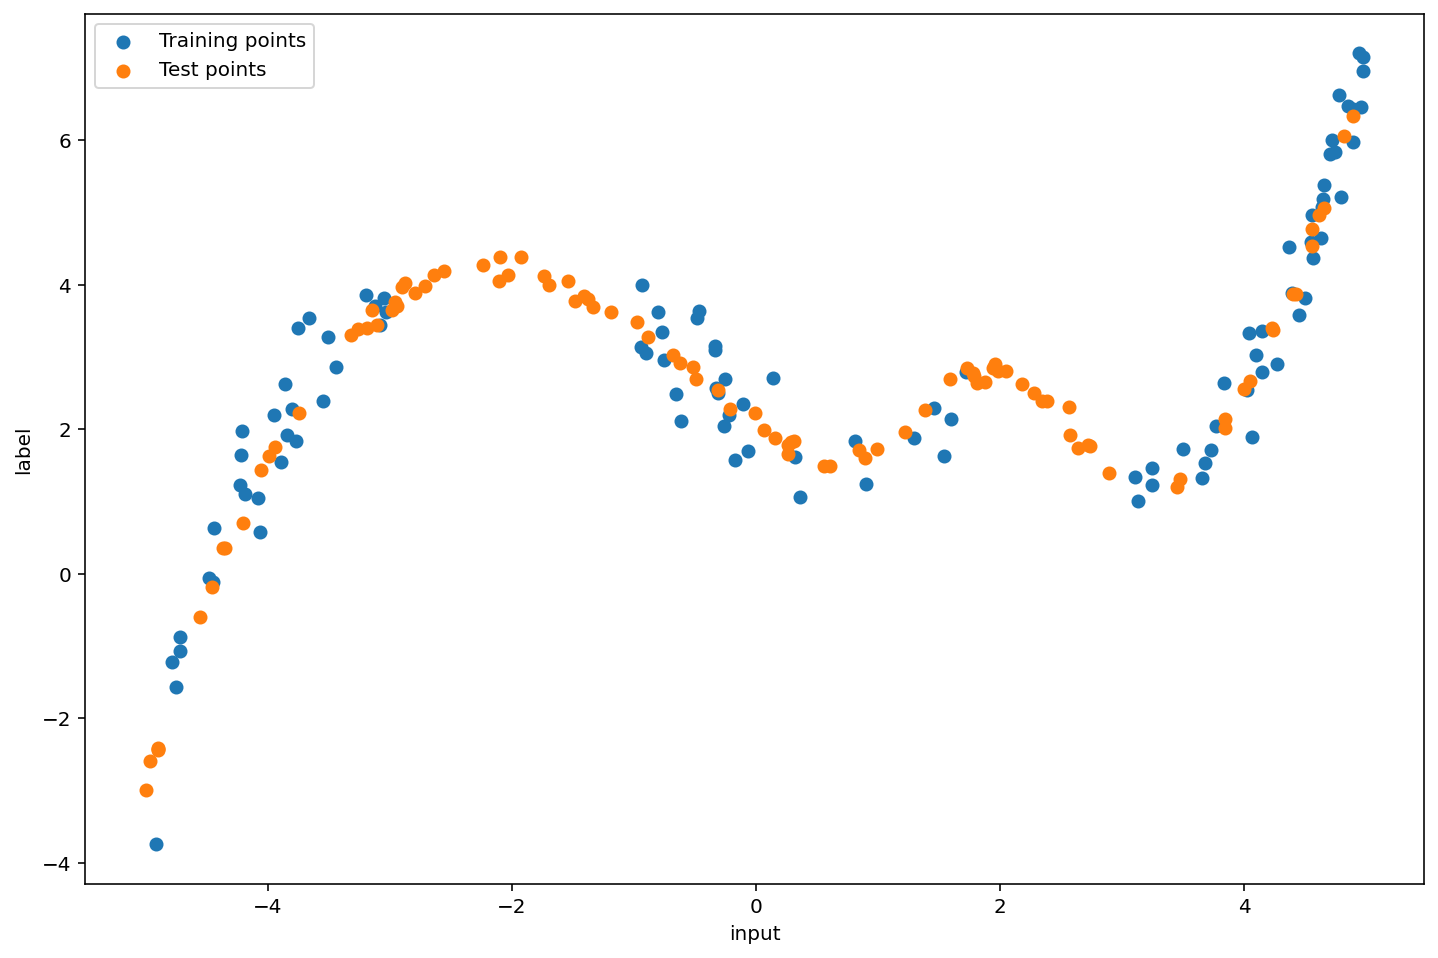

In [5]:
fig = plt.figure(figsize=(12,8))
plt.scatter(train_df.input, train_df.label, label='Training points')
plt.scatter(test_df.input, test_df.label, label='Test points')
plt.xlabel('input')
plt.ylabel('label')
plt.legend()
plt.show()

## Simple Regression Model using NN

Transforming the dataframe to tensor

In [6]:
class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):
        x, y = sample
        return (torch.Tensor([x]).float(),
                torch.Tensor([y]).float())

In [7]:
class CsvDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.transform = transform
        # Read the file and split the lines in a list
        with open(csv_file, 'r') as f:
            next(f) #skip the header
            lines = f.read().split('\n')
        # Get x and y values from each line and append to self.data
        self.data = []
        for line in lines:
            sample = line.split(',')
            self.data.append((float(sample[0]), float(sample[1])))
                
        # Now self.data contains all our dataset.
        # Each element of the list self.data is a tuple: (input, output)

    def __len__(self):
        # The length of the dataset is simply the length of the self.data list
        return len(self.data)

    def __getitem__(self, idx):
        # Our sample is the element idx of the list self.data
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

In [8]:
composed_transform = transforms.Compose([
  ToTensor(),
  ])

In [9]:
train_ = CsvDataset('regression_dataset/train_data.csv', transform=composed_transform)
test_ = CsvDataset('regression_dataset/test_data.csv', transform=composed_transform)

In [10]:
print(train_[60])
print(test_[0])

(tensor([3.4972]), tensor([1.7237]))
(tensor([-0.6232]), tensor([2.9088]))


Create a validation set from the training set

In [11]:
train_size = int(0.8 * len(train_))
val_size = len(train_) - train_size
train_, val_ = torch.utils.data.random_split(train_, [train_size, val_size])

In [12]:
print('Training size:',len(train_))
print('Validation size:',len(val_))
print('Test size:',len(test_))

Training size: 80
Validation size: 20
Test size: 100


In [13]:
trainloader = DataLoader(train_, batch_size=len(train_), shuffle=True, num_workers=0)
testloader = DataLoader(test_, batch_size=len(test_), shuffle=False, num_workers=0)
valloader = DataLoader(val_, batch_size=len(val_), shuffle=False, num_workers=0)

Run on GPU/CPU

In [14]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cpu


## Model Regression

- Without optimization

In [15]:
# Define a LightningModule (nn.Module subclass)
# A LightningModule defines a full system (ie: a GAN, autoencoder, BERT or a simple Image Classifier).
class Net(pl.LightningModule):
    def __init__(self, Nh1, Nh2, drop1, drop2):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        """
        super().__init__()
        
        print('Network initialized')
        self.net = nn.Sequential(
                       nn.Linear(in_features=1, out_features=Nh1), 
                       nn.ReLU(), 
                       nn.Dropout(p=drop1),
                       nn.Linear(in_features=Nh1, out_features=Nh2),
                       nn.ReLU(),
                       nn.Dropout(p=drop2),
                       nn.Linear(in_features=Nh2, out_features=1),
        )
        self.val_loss = []
        self.train_loss = []

    # Forward step defines how the LightningModule behaves during inference/prediction.
    def forward(self, x, additional_out=False):
        return self.net(x)

    # Training_step defines the training loop. 
    def training_step(self, batch, batch_idx=None):
        # training_step defines the train loop. It is independent of forward
        x_batch = batch[0]
        label_batch = batch[1]
        out = self.net(x_batch)
        loss = F.mse_loss(out, label_batch)
        self.train_loss.append(loss)
        self.log("val_loss", loss.item())
        return loss

    def validation_step(self, batch, batch_idx=None):
        # training_step defines the train loop. It is independent of forward
        x_batch = batch[0]
        label_batch = batch[1]
        out = self.net(x_batch)
        loss = F.mse_loss(out, label_batch)
        self.val_loss.append(loss.item())

    def configure_optimizers(self):
        optimizer = optim.Adam(self.net.parameters(), lr=1e-3)
        return optimizer

In [16]:
# TRAIN!
batch_size = 200
train_dataloader = DataLoader(train_, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader   = DataLoader(val_,   batch_size=len(val_), shuffle=False, num_workers=0)
test_dataloader  = DataLoader(test_,  batch_size=len(test_), shuffle=False, num_workers=0)


# Initialize the network
torch.manual_seed(0)
net = Net( Nh1=256, Nh2=256, drop1=0., drop2=0.)
print(net.to(device))

# Define the loss function
loss_function = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=1e-3)

#Flexible learning rateimport torch.optim.lr_scheduler.StepLR
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

Network initialized
Net(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [17]:
trainer = pl.Trainer(gpus=0, max_epochs=350, val_check_interval=1)
trainer.fit(net, train_dataloader, val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 66.6 K
------------------------------------
66.6 K    Trainable params
0         Non-trainable params
66.6 K    Total params
0.266     Total estimated model params size (MB)


C:\Users\filip\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:110: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\filip\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:110: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\filip\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:393: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want 

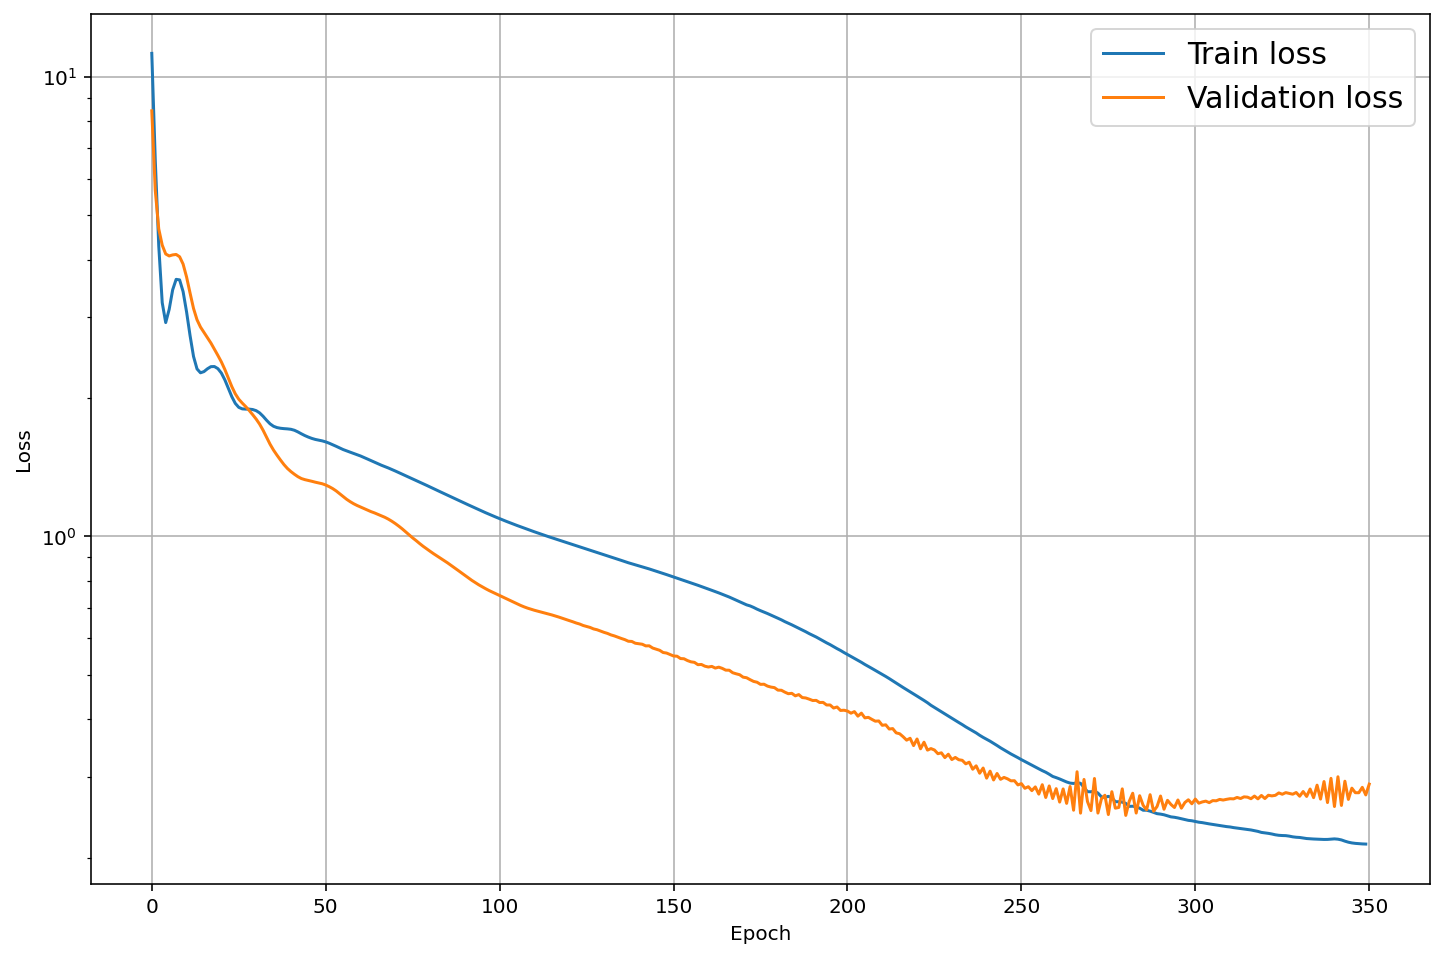

In [18]:
# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(net.train_loss, label='Train loss')
plt.semilogy(net.val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid('on')
plt.legend(loc=1,prop={'size': 15})
plt.show()

Input shape: torch.Size([1000, 1])
Output shape: torch.Size([1000, 1])


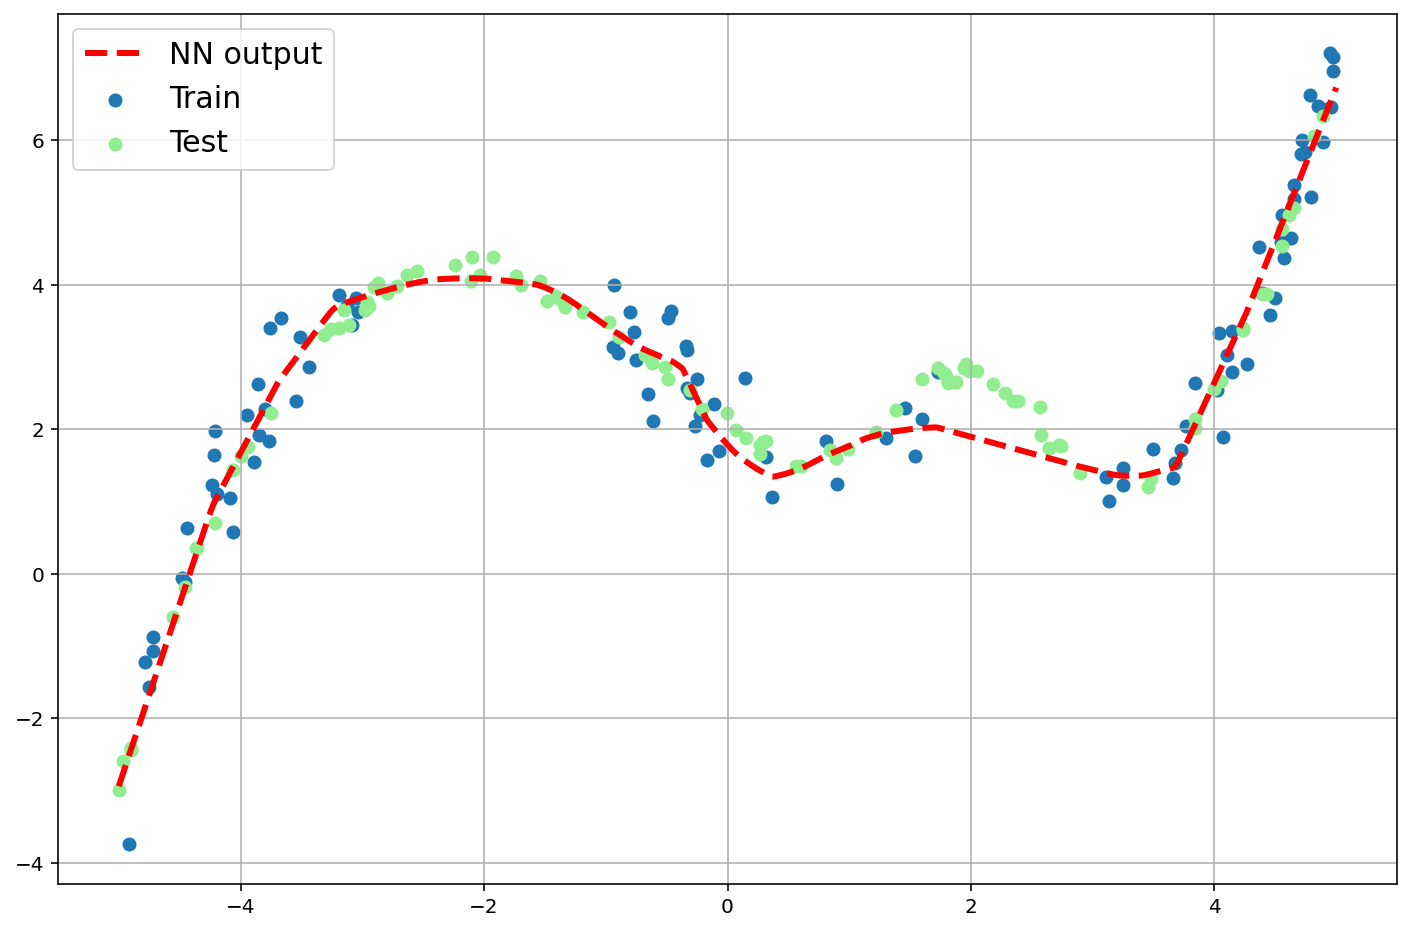

In [19]:
# Input vector
x_vec = torch.linspace(-5,5,1000)
x_vec = x_vec.unsqueeze(-1).to(device)  # Adding a dimension to the input vector
print(f"Input shape: {x_vec.shape}")

#with 
#y_vec = trainer.predict(litnet,x_vec)
#print(f"Output shape: {y_vec.shape}")
net.eval()
with torch.no_grad(): # turn off gradients computation
    y_vec = net(x_vec)
print(f"Output shape: {y_vec.shape}")


plt.figure(figsize=(12,8))
plt.plot(x_vec,y_vec,'r--', label='NN output',linewidth=3)
plt.scatter(train_df.iloc[0:,0], train_df.iloc[0:,1], label='Train')
plt.scatter(test_df.iloc[0:,0], test_df.iloc[0:,1], label='Test',color='lightgreen')
plt.grid('on')
plt.legend(loc=2,prop={'size': 15})
plt.show()

- The model overfits for 350 epochs, it should be stopped at arounf 300.
- Also it seems that between (1.5,3.5) the model fits well the training but fails to predict the regression for the test.

# Model Regression
- With optimization
- With KFold cross-validation $k=5$

### Hyperparameter Optimization

In [22]:
def objective(trial):

    # We optimize the number of hidden units in each layer.
    n_l1 = trial.suggest_int("n_l1", 100, 300)
    n_l2 = trial.suggest_int("n_l2", 100, 300)
    p1 = trial.suggest_float("dropout_l1", 0., 0.4)
    p2 = trial.suggest_float("dropout_l2", 0., 0.4)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
    weight_norm = trial.suggest_loguniform('weigth_norm',1e-4, 1e0)
    optimizer = getattr(optim, optimizer_name)(net.parameters(), lr=lr, weight_decay=weight_norm)


    model = Net(n_l1, n_l2, p1, p2)
    early_stop = pl.callbacks.EarlyStopping('val_loss', patience=50)
    trainer = pl.Trainer(gpus=0, max_epochs=300, val_check_interval=1, log_every_n_steps=1,callbacks=[early_stop])

    hyperparameters = dict(
                           optimizer=optimizer_name,
                           lr = lr,
                            weight_norm=weight_norm,
                            n_l1=n_l1,
                            n_l2=n_l2,
                            dropout_l1 = p1,
                            dropout_l2=p2)
                            
    
    trainer.logger.log_hyperparams(hyperparameters)
    
    
    trainer.fit(model, train_dataloader, val_dataloader)

    return trainer.callback_metrics["val_loss"].item()

pruner: optuna.pruners.BasePruner = optuna.pruners.NopPruner()
# print(pruner) <optuna.pruners._nop.NopPruner object at 0x7f4c2466ed50>
# print(type(pruner)) <class 'optuna.pruners._nop.NopPruner'>

In [23]:
study = optuna.create_study(study_name="myfirstoptimizationstudy", direction="minimize", pruner=pruner)
study.optimize(objective, n_trials=20, timeout=600)

[I 2021-11-11 17:49:18,668] A new study created in memory with name: myfirstoptimizationstudy
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 70.0 K
------------------------------------
70.0 K    Trainable params
0         Non-trainable params
70.0 K    Total params
0.280     Total estimated model params size (MB)


Network initialized


C:\Users\filip\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:110: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\filip\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:110: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


[I 2021-11-11 17:49:51,401] Trial 0 finished with value: 0.8057467341423035 and parameters: {'n_l1': 260, 'n_l2': 265, 'dropout_l1': 0.23409857275406162, 'dropout_l2': 0.23317623287836106, 'optimizer': 'Adam', 'lr': 1.3085380892669326e-05, 'weigth_norm': 0.024974542917831757}. Best is trial 0 with value: 0.8057467341423035.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 25.7 K
------------------------------------
25.7 K    Trainable params
0         Non-trainable params
25.7 K    Total params
0.103     Total estimated model params size (MB)



Network initialized


C:\Users\filip\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:110: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\filip\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:110: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


[I 2021-11-11 17:50:19,344] Trial 1 finished with value: 0.8215271234512329 and parameters: {'n_l1': 199, 'n_l2': 126, 'dropout_l1': 0.1491996338120963, 'dropout_l2': 0.019338922620361434, 'optimizer': 'Adam', 'lr': 0.00010209926313188923, 'weigth_norm': 0.0031333729394858677}. Best is trial 0 with value: 0.8057467341423035.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs



Network initialized



  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 70.0 K
------------------------------------
70.0 K    Trainable params
0         Non-trainable params
70.0 K    Total params
0.280     Total estimated model params size (MB)


C:\Users\filip\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:110: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\filip\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:110: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


[I 2021-11-11 17:50:47,125] Trial 2 finished with value: 0.6642366647720337 and parameters: {'n_l1': 292, 'n_l2': 236, 'dropout_l1': 0.07475158815144099, 'dropout_l2': 0.1936780426656886, 'optimizer': 'Adam', 'lr': 0.009116416753164061, 'weigth_norm': 0.14555997401353865}. Best is trial 2 with value: 0.6642366647720337.
GPU available: False, used: False



Network initialized


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 64.3 K
------------------------------------
64.3 K    Trainable params
0         Non-trainable params
64.3 K    Total params
0.257     Total estimated model params size (MB)


C:\Users\filip\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:110: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\filip\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:110: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


[I 2021-11-11 17:51:18,082] Trial 3 finished with value: 0.44942837953567505 and parameters: {'n_l1': 266, 'n_l2': 238, 'dropout_l1': 0.035700940129226845, 'dropout_l2': 0.003823938659104398, 'optimizer': 'SGD', 'lr': 0.0011601093048352073, 'weigth_norm': 0.02236422570383788}. Best is trial 3 with value: 0.44942837953567505.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs



Network initialized



  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 15.4 K
------------------------------------
15.4 K    Trainable params
0         Non-trainable params
15.4 K    Total params
0.062     Total estimated model params size (MB)


C:\Users\filip\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:110: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\filip\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:110: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


[I 2021-11-11 17:51:40,269] Trial 4 finished with value: 1.7822822332382202 and parameters: {'n_l1': 109, 'n_l2': 137, 'dropout_l1': 0.3988967022524534, 'dropout_l2': 0.12537186201756403, 'optimizer': 'SGD', 'lr': 3.907567400692853e-05, 'weigth_norm': 0.6011257753181095}. Best is trial 3 with value: 0.44942837953567505.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs



Network initialized



  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 25.8 K
------------------------------------
25.8 K    Trainable params
0         Non-trainable params
25.8 K    Total params
0.103     Total estimated model params size (MB)


C:\Users\filip\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:110: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\filip\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:110: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


[I 2021-11-11 17:51:54,671] Trial 5 finished with value: 2.0121500492095947 and parameters: {'n_l1': 171, 'n_l2': 147, 'dropout_l1': 0.368146684914947, 'dropout_l2': 0.37305869370788525, 'optimizer': 'Adam', 'lr': 0.003804008995652116, 'weigth_norm': 0.008782170602685825}. Best is trial 3 with value: 0.44942837953567505.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 83.8 K
------------------------------------
83.8 K    Trainable params
0         Non-trainable params
83.8 K    Total params
0.335     Total estimated model params size (MB)


Network initialized


C:\Users\filip\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:110: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\filip\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:110: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


[I 2021-11-11 17:52:22,462] Trial 6 finished with value: 0.4962595999240875 and parameters: {'n_l1': 291, 'n_l2': 284, 'dropout_l1': 0.04302950346070067, 'dropout_l2': 0.11330273429070754, 'optimizer': 'SGD', 'lr': 4.7599363193575186e-05, 'weigth_norm': 0.0032289037051208306}. Best is trial 3 with value: 0.44942837953567505.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Network initialized



  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 69.4 K
------------------------------------
69.4 K    Trainable params
0         Non-trainable params
69.4 K    Total params
0.277     Total estimated model params size (MB)


C:\Users\filip\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:110: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\filip\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:110: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


[I 2021-11-11 17:52:48,286] Trial 7 finished with value: 0.5269020199775696 and parameters: {'n_l1': 253, 'n_l2': 270, 'dropout_l1': 0.04280779610826011, 'dropout_l2': 0.287010027793217, 'optimizer': 'SGD', 'lr': 0.001986647978886662, 'weigth_norm': 0.0001701015732253191}. Best is trial 3 with value: 0.44942837953567505.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Network initialized



  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 68.0 K
------------------------------------
68.0 K    Trainable params
0         Non-trainable params
68.0 K    Total params
0.272     Total estimated model params size (MB)


C:\Users\filip\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:110: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\filip\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:110: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


[I 2021-11-11 17:53:15,222] Trial 8 finished with value: 0.5846769213676453 and parameters: {'n_l1': 240, 'n_l2': 279, 'dropout_l1': 0.0907965999924111, 'dropout_l2': 0.11206715883874906, 'optimizer': 'Adam', 'lr': 0.00011604291100394857, 'weigth_norm': 0.002426021819454402}. Best is trial 3 with value: 0.44942837953567505.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 29.1 K
------------------------------------
29.1 K    Trainable params
0         Non-trainable params
29.1 K    Total params
0.116     Total estimated model params size (MB)


Network initialized


C:\Users\filip\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:110: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\filip\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:110: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


[I 2021-11-11 17:53:42,907] Trial 9 finished with value: 0.8530693054199219 and parameters: {'n_l1': 206, 'n_l2': 138, 'dropout_l1': 0.15360022585821334, 'dropout_l2': 0.041072027012286544, 'optimizer': 'SGD', 'lr': 0.0005446749680080965, 'weigth_norm': 0.00010837897223083682}. Best is trial 3 with value: 0.44942837953567505.
GPU available: False, used: False



Network initialized


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 23.4 K
------------------------------------
23.4 K    Trainable params
0         Non-trainable params
23.4 K    Total params
0.094     Total estimated model params size (MB)


C:\Users\filip\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:110: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\filip\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:110: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


[I 2021-11-11 17:54:11,194] Trial 10 finished with value: 1.4568910598754883 and parameters: {'n_l1': 120, 'n_l2': 190, 'dropout_l1': 0.2713084381579709, 'dropout_l2': 0.3653111001614698, 'optimizer': 'SGD', 'lr': 0.000569499822168109, 'weigth_norm': 0.07465103732663353}. Best is trial 3 with value: 0.44942837953567505.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 67.0 K
------------------------------------
67.0 K    Trainable params
0         Non-trainable params
67.0 K    Total params
0.268     Total estimated model params size (MB)



Network initialized


C:\Users\filip\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:110: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\filip\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:110: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


[I 2021-11-11 17:54:42,011] Trial 11 finished with value: 0.47363296151161194 and parameters: {'n_l1': 297, 'n_l2': 222, 'dropout_l1': 0.029519219399709598, 'dropout_l2': 0.09347059914007635, 'optimizer': 'SGD', 'lr': 0.00019258598659810912, 'weigth_norm': 0.00102976629160844}. Best is trial 3 with value: 0.44942837953567505.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs



Network initialized



  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 62.9 K
------------------------------------
62.9 K    Trainable params
0         Non-trainable params
62.9 K    Total params
0.252     Total estimated model params size (MB)


C:\Users\filip\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:110: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\filip\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:110: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


[I 2021-11-11 17:55:12,739] Trial 12 finished with value: 0.27379152178764343 and parameters: {'n_l1': 296, 'n_l2': 209, 'dropout_l1': 0.002912441203824917, 'dropout_l2': 0.013483047049482458, 'optimizer': 'SGD', 'lr': 0.0011037951586871653, 'weigth_norm': 0.0005085166481961624}. Best is trial 12 with value: 0.27379152178764343.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs



Network initialized



  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 42.8 K
------------------------------------
42.8 K    Trainable params
0         Non-trainable params
42.8 K    Total params
0.171     Total estimated model params size (MB)


C:\Users\filip\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:110: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\filip\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:110: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


[I 2021-11-11 17:55:40,302] Trial 13 finished with value: 0.36004868149757385 and parameters: {'n_l1': 227, 'n_l2': 185, 'dropout_l1': 0.00999932728009624, 'dropout_l2': 0.005072727465560213, 'optimizer': 'SGD', 'lr': 0.0011582501695404474, 'weigth_norm': 0.0006112930985757314}. Best is trial 12 with value: 0.27379152178764343.



Network initialized

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 40.7 K
------------------------------------
40.7 K    Trainable params
0         Non-trainable params
40.7 K    Total params
0.163     Total estimated model params size (MB)


C:\Users\filip\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:110: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\filip\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:110: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


[I 2021-11-11 17:56:09,547] Trial 14 finished with value: 0.47141122817993164 and parameters: {'n_l1': 223, 'n_l2': 179, 'dropout_l1': 0.007099245364358835, 'dropout_l2': 0.056745483952614646, 'optimizer': 'SGD', 'lr': 0.001596692098855144, 'weigth_norm': 0.0004766960063236572}. Best is trial 12 with value: 0.27379152178764343.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs



Network initialized



  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 16.7 K
------------------------------------
16.7 K    Trainable params
0         Non-trainable params
16.7 K    Total params
0.067     Total estimated model params size (MB)


C:\Users\filip\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:110: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\filip\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:110: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


[I 2021-11-11 17:56:36,578] Trial 15 finished with value: 1.1103930473327637 and parameters: {'n_l1': 160, 'n_l2': 101, 'dropout_l1': 0.15198432335719633, 'dropout_l2': 0.1753415616830548, 'optimizer': 'SGD', 'lr': 0.004371414377789445, 'weigth_norm': 0.0004779220357439401}. Best is trial 12 with value: 0.27379152178764343.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs



Network initialized



  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 29.1 K
------------------------------------
29.1 K    Trainable params
0         Non-trainable params
29.1 K    Total params
0.116     Total estimated model params size (MB)


C:\Users\filip\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:110: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\filip\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:110: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


[I 2021-11-11 17:57:06,443] Trial 16 finished with value: 0.7456436157226562 and parameters: {'n_l1': 169, 'n_l2': 168, 'dropout_l1': 0.10000225532740735, 'dropout_l2': 0.07352153685168294, 'optimizer': 'SGD', 'lr': 0.0005006818161494372, 'weigth_norm': 0.0006876897217849736}. Best is trial 12 with value: 0.27379152178764343.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 57.3 K
------------------------------------
57.3 K    Trainable params
0         Non-trainable params
57.3 K    Total params
0.229     Total estimated model params size (MB)



Network initialized


C:\Users\filip\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:110: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\filip\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:110: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


[I 2021-11-11 17:57:27,854] Trial 17 finished with value: 1.336868166923523 and parameters: {'n_l1': 272, 'n_l2': 207, 'dropout_l1': 0.3147127358850152, 'dropout_l2': 0.002124901737339615, 'optimizer': 'SGD', 'lr': 0.0010293831839435974, 'weigth_norm': 0.00017172025232755887}. Best is trial 12 with value: 0.27379152178764343.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs



Network initialized



  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 47.9 K
------------------------------------
47.9 K    Trainable params
0         Non-trainable params
47.9 K    Total params
0.192     Total estimated model params size (MB)


C:\Users\filip\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:110: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\filip\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:110: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


[I 2021-11-11 17:57:55,303] Trial 18 finished with value: 0.43657857179641724 and parameters: {'n_l1': 225, 'n_l2': 209, 'dropout_l1': 0.0005944255717174672, 'dropout_l2': 0.16434522558721953, 'optimizer': 'SGD', 'lr': 0.003321490579480951, 'weigth_norm': 0.0011781919953640055}. Best is trial 12 with value: 0.27379152178764343.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs



Network initialized



  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 32.4 K
------------------------------------
32.4 K    Trainable params
0         Non-trainable params
32.4 K    Total params
0.129     Total estimated model params size (MB)


C:\Users\filip\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:110: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\filip\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:110: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


[I 2021-11-11 17:58:26,250] Trial 19 finished with value: 0.760395884513855 and parameters: {'n_l1': 193, 'n_l2': 164, 'dropout_l1': 0.19753746868525943, 'dropout_l2': 0.25743373742435366, 'optimizer': 'SGD', 'lr': 0.00029237546631680363, 'weigth_norm': 0.007596532085833264}. Best is trial 12 with value: 0.27379152178764343.


In [24]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 20
Best trial:
  Value: 0.27379152178764343
  Params: 
    n_l1: 296
    n_l2: 209
    dropout_l1: 0.002912441203824917
    dropout_l2: 0.013483047049482458
    optimizer: SGD
    lr: 0.0011037951586871653
    weigth_norm: 0.0005085166481961624


In [25]:
optuna.visualization.plot_param_importances(study)

In [26]:
optuna.visualization.plot_slice(study)

In [27]:
plot_parallel_coordinate(study)

In [28]:
plot_optimization_history(study)

In [52]:
plot_contour(study, params=['n_l2','n_l1'])

## Best model

Defining the Architecture

In [34]:
class Net(nn.Module):
    def __init__(self, Nh1: int, Nh2: int, drop1 = 0. , drop2= 0.):
        '''
        Constructor that builds a Neural Network with 2 hidden layers
        and accepts the following parameters:
        Nh1 (int) : number of units in first hidden layer
        Nh2 (int) : number of units in second hidden layer
        drop1 (float) : probability of dropout first hidden layer
        drop2 (float) : probability of dropout second hidden layer
        '''
        super().__init__()

        #Network architecture related code
        self.fc1 = nn.Linear(in_features=1, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.out = nn.Linear(in_features=Nh2, out_features=1)
        
        #Activation function related code 
        self.act = nn.ReLU()

        #Dropout related code
        self.drop1 = nn.Dropout(p = drop1)
        self.drop2 = nn.Dropout(p = drop2)

        print("Network initialized!")


    def forward(self, x, additional_out=False):
        #first hidden layer related code
        x1 = self.act(self.fc1(x))
        x1 = self.drop1(x1)
        #second hidden layer related code
        x2 = self.act(self.fc2(x1))
        x2 = self.drop2(x2)
        #output layer
        out = self.out(x2)

        return out


In [38]:
### TRAINING LOOP
def train_epochs(num_epochs, patience, trainloader, valloader,
                 Nh1, Nh2, drop1, drop2):
    
    early_stopping = EarlyStopping(patience=patience, verbose=True) #early stopping
    model = Net(Nh1=Nh1, Nh2=Nh2,drop1=drop1,drop2=drop2).to(device)
    loss_function = nn.MSELoss()
    optimizer=optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.0005)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.1)
    
    train_loss_log = []
    val_loss_log = []
    for epoch_num in range(num_epochs):
        print('#################')
        print(f'# EPOCH {epoch_num}')
        print('#################')

        ### TRAIN
        train_loss= []
        model.train() # Training mode (e.g. enable dropout, batchnorm updates,...)
        
        for sample_batched in trainloader:
            # Move data to device
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)

            # Forward pass
            out = model(x_batch)

            # Compute loss
            loss = loss_function(out, label_batch)

            # Backpropagation
            model.zero_grad()
            loss.backward()

            # Update the weights
            optimizer.step()

            # Save train loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            train_loss.append(loss_batch)

        # Save average train loss
        train_loss = np.mean(train_loss)
        print(f"AVERAGE TRAIN LOSS: {train_loss}")
        train_loss_log.append(train_loss)
    
        ### VALIDATION
        val_loss= []
        model.eval() # Evaluation mode (e.g. disable dropout, batchnorm,...)
        with torch.no_grad(): # Disable gradient tracking
            for sample_batched in valloader:
                # Move data to device
                x_batch = sample_batched[0].to(device)
                label_batch = sample_batched[1].to(device)

                # Forward pass
                out = model(x_batch)

                # Compute loss
                loss = loss_function(out, label_batch)

                # Save val loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                val_loss.append(loss_batch)

            # Save average validation loss
            val_loss = np.mean(val_loss)
            print(f"AVERAGE VAL LOSS: {np.mean(val_loss)}")
            val_loss_log.append(val_loss)
            
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(val_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
            
        scheduler.step() #updating the learning rate
        
    model.apply(reset_weights)
        
    return train_loss_log, val_loss_log
    
    

In [36]:
def reset_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()
        
train_ = CsvDataset('regression_dataset/train_data.csv', transform=composed_transform)

def crossvalid( dataset,k_fold, epochs, patience,
               Nh1, Nh2, drop1, drop2):
    
    train_score = pd.Series()
    val_score = pd.Series()
    
    total_size = len(dataset)
    fraction = 1/k_fold
    seg = int(total_size * fraction)

    for i in range(k_fold):
        trll = 0
        trlr = i * seg
        vall = trlr
        valr = i * seg + seg
        trrl = valr
        trrr = total_size

        train_left_indices = list(range(trll,trlr))
        train_right_indices = list(range(trrl,trrr))
        
        train_indices = train_left_indices + train_right_indices
        val_indices = list(range(vall,valr))
                
        train_set = torch.utils.data.dataset.Subset(dataset,train_indices)
        val_set = torch.utils.data.dataset.Subset(dataset,val_indices)
        
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=50,
                                          shuffle=False, num_workers=0)
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=50,
                                          shuffle=False, num_workers=0)

        
        train_acc, val_acc = train_epochs(epochs,patience, train_loader, val_loader, 
                                          Nh1, Nh2, drop1, drop2)
        train_score.at[i] = train_acc
        val_score.at[i] = val_acc
        
    train_loss = np.array([train_score[0],train_score[1],train_score[2], train_score[3],train_score[4]]).mean(axis=0)
    val_loss = np.array([val_score[0],val_score[1],val_score[2], val_score[3], val_score[4]]).mean(axis=0)
    
    return train_loss,val_loss

In [33]:
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

  Params: 
    n_l1: 296
    n_l2: 209
    dropout_l1: 0.002912441203824917
    dropout_l2: 0.013483047049482458
    optimizer: SGD
    lr: 0.0011037951586871653
    weigth_norm: 0.0005085166481961624


In [39]:
n_epochs=800
patience=1000

dataset = CsvDataset('regression_dataset/test_data.csv', transform=composed_transform)
train_loss,val_loss = crossvalid(dataset=dataset, k_fold=5, epochs=n_epochs,patience=patience,
                                Nh1=296,Nh2=209,drop1=0.003,drop2=0.013)

<ipython-input-36-d9908d363a58>:10: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

<ipython-input-36-d9908d363a58>:11: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



Network initialized!
#################
# EPOCH 0
#################
AVERAGE TRAIN LOSS: 8.853428840637207
AVERAGE VAL LOSS: 7.768853187561035
Validation loss decreased (inf --> 7.768853).  Saving model ...
#################
# EPOCH 1
#################
AVERAGE TRAIN LOSS: 5.091649055480957
AVERAGE VAL LOSS: 6.537288665771484
Validation loss decreased (7.768853 --> 6.537289).  Saving model ...
#################
# EPOCH 2
#################
AVERAGE TRAIN LOSS: 3.674093723297119
AVERAGE VAL LOSS: 5.395901679992676
Validation loss decreased (6.537289 --> 5.395902).  Saving model ...
#################
# EPOCH 3
#################
AVERAGE TRAIN LOSS: 3.3458092212677
AVERAGE VAL LOSS: 4.7129340171813965
Validation loss decreased (5.395902 --> 4.712934).  Saving model ...
#################
# EPOCH 4
#################
AVERAGE TRAIN LOSS: 3.398861885070801
AVERAGE VAL LOSS: 4.1243438720703125
Validation loss decreased (4.712934 --> 4.124344).  Saving model ...
#################
# EPOCH 5
###########

AVERAGE VAL LOSS: 0.39590126276016235
EarlyStopping counter: 1 out of 1000
#################
# EPOCH 51
#################
AVERAGE TRAIN LOSS: 0.384094774723053
AVERAGE VAL LOSS: 0.4470096230506897
EarlyStopping counter: 2 out of 1000
#################
# EPOCH 52
#################
AVERAGE TRAIN LOSS: 0.3841884136199951
AVERAGE VAL LOSS: 0.3560551702976227
Validation loss decreased (0.379538 --> 0.356055).  Saving model ...
#################
# EPOCH 53
#################
AVERAGE TRAIN LOSS: 0.39267241954803467
AVERAGE VAL LOSS: 0.3434871435165405
Validation loss decreased (0.356055 --> 0.343487).  Saving model ...
#################
# EPOCH 54
#################
AVERAGE TRAIN LOSS: 0.36601173877716064
AVERAGE VAL LOSS: 0.42559510469436646
EarlyStopping counter: 1 out of 1000
#################
# EPOCH 55
#################
AVERAGE TRAIN LOSS: 0.3881336450576782
AVERAGE VAL LOSS: 0.3768809735774994
EarlyStopping counter: 2 out of 1000
#################
# EPOCH 56
#################
AVERAGE TRAI

AVERAGE VAL LOSS: 0.17212946712970734
EarlyStopping counter: 1 out of 1000
#################
# EPOCH 111
#################
AVERAGE TRAIN LOSS: 0.20049144327640533
AVERAGE VAL LOSS: 0.16188447177410126
EarlyStopping counter: 2 out of 1000
#################
# EPOCH 112
#################
AVERAGE TRAIN LOSS: 0.19466479122638702
AVERAGE VAL LOSS: 0.14272306859493256
Validation loss decreased (0.159666 --> 0.142723).  Saving model ...
#################
# EPOCH 113
#################
AVERAGE TRAIN LOSS: 0.1725849211215973
AVERAGE VAL LOSS: 0.16105987131595612
EarlyStopping counter: 1 out of 1000
#################
# EPOCH 114
#################
AVERAGE TRAIN LOSS: 0.16681212186813354
AVERAGE VAL LOSS: 0.14814597368240356
EarlyStopping counter: 2 out of 1000
#################
# EPOCH 115
#################
AVERAGE TRAIN LOSS: 0.16076461970806122
AVERAGE VAL LOSS: 0.13603542745113373
Validation loss decreased (0.142723 --> 0.136035).  Saving model ...
#################
# EPOCH 116
#################

AVERAGE VAL LOSS: 0.04896347224712372
EarlyStopping counter: 6 out of 1000
#################
# EPOCH 163
#################
AVERAGE TRAIN LOSS: 0.07750406861305237
AVERAGE VAL LOSS: 0.043477863073349
Validation loss decreased (0.047327 --> 0.043478).  Saving model ...
#################
# EPOCH 164
#################
AVERAGE TRAIN LOSS: 0.0649111196398735
AVERAGE VAL LOSS: 0.04340719059109688
Validation loss decreased (0.043478 --> 0.043407).  Saving model ...
#################
# EPOCH 165
#################
AVERAGE TRAIN LOSS: 0.06502138078212738
AVERAGE VAL LOSS: 0.048245906829833984
EarlyStopping counter: 1 out of 1000
#################
# EPOCH 166
#################
AVERAGE TRAIN LOSS: 0.057948265224695206
AVERAGE VAL LOSS: 0.0395113006234169
Validation loss decreased (0.043407 --> 0.039511).  Saving model ...
#################
# EPOCH 167
#################
AVERAGE TRAIN LOSS: 0.0700807273387909
AVERAGE VAL LOSS: 0.0577811598777771
EarlyStopping counter: 1 out of 1000
#################


AVERAGE TRAIN LOSS: 0.03299430385231972
AVERAGE VAL LOSS: 0.02421770617365837
EarlyStopping counter: 6 out of 1000
#################
# EPOCH 212
#################
AVERAGE TRAIN LOSS: 0.03921781852841377
AVERAGE VAL LOSS: 0.024426031857728958
EarlyStopping counter: 7 out of 1000
#################
# EPOCH 213
#################
AVERAGE TRAIN LOSS: 0.0652361512184143
AVERAGE VAL LOSS: 0.023502856492996216
EarlyStopping counter: 8 out of 1000
#################
# EPOCH 214
#################
AVERAGE TRAIN LOSS: 0.05358780920505524
AVERAGE VAL LOSS: 0.024202220141887665
EarlyStopping counter: 9 out of 1000
#################
# EPOCH 215
#################
AVERAGE TRAIN LOSS: 0.04171773046255112
AVERAGE VAL LOSS: 0.026829680427908897
EarlyStopping counter: 10 out of 1000
#################
# EPOCH 216
#################
AVERAGE TRAIN LOSS: 0.026053929701447487
AVERAGE VAL LOSS: 0.029597187414765358
EarlyStopping counter: 11 out of 1000
#################
# EPOCH 217
#################
AVERAGE TRAIN L

AVERAGE TRAIN LOSS: 0.034317560493946075
AVERAGE VAL LOSS: 0.02292245253920555
EarlyStopping counter: 4 out of 1000
#################
# EPOCH 270
#################
AVERAGE TRAIN LOSS: 0.043074168264865875
AVERAGE VAL LOSS: 0.023580042645335197
EarlyStopping counter: 5 out of 1000
#################
# EPOCH 271
#################
AVERAGE TRAIN LOSS: 0.025949768722057343
AVERAGE VAL LOSS: 0.024768706411123276
EarlyStopping counter: 6 out of 1000
#################
# EPOCH 272
#################
AVERAGE TRAIN LOSS: 0.03268776088953018
AVERAGE VAL LOSS: 0.024956893175840378
EarlyStopping counter: 7 out of 1000
#################
# EPOCH 273
#################
AVERAGE TRAIN LOSS: 0.05002683028578758
AVERAGE VAL LOSS: 0.02448558434844017
EarlyStopping counter: 8 out of 1000
#################
# EPOCH 274
#################
AVERAGE TRAIN LOSS: 0.025177326053380966
AVERAGE VAL LOSS: 0.023376336321234703
EarlyStopping counter: 9 out of 1000
#################
# EPOCH 275
#################
AVERAGE TRAIN 

AVERAGE VAL LOSS: 0.022427640855312347
EarlyStopping counter: 36 out of 1000
#################
# EPOCH 328
#################
AVERAGE TRAIN LOSS: 0.03647284209728241
AVERAGE VAL LOSS: 0.02375688962638378
EarlyStopping counter: 37 out of 1000
#################
# EPOCH 329
#################
AVERAGE TRAIN LOSS: 0.04830990731716156
AVERAGE VAL LOSS: 0.023995745927095413
EarlyStopping counter: 38 out of 1000
#################
# EPOCH 330
#################
AVERAGE TRAIN LOSS: 0.027924586087465286
AVERAGE VAL LOSS: 0.021995943039655685
EarlyStopping counter: 39 out of 1000
#################
# EPOCH 331
#################
AVERAGE TRAIN LOSS: 0.03313375636935234
AVERAGE VAL LOSS: 0.021635988727211952
EarlyStopping counter: 40 out of 1000
#################
# EPOCH 332
#################
AVERAGE TRAIN LOSS: 0.06283345073461533
AVERAGE VAL LOSS: 0.023307403549551964
EarlyStopping counter: 41 out of 1000
#################
# EPOCH 333
#################
AVERAGE TRAIN LOSS: 0.04128313809633255
AVERAGE VA

AVERAGE VAL LOSS: 0.02400193177163601
EarlyStopping counter: 13 out of 1000
#################
# EPOCH 379
#################
AVERAGE TRAIN LOSS: 0.03491409868001938
AVERAGE VAL LOSS: 0.022613205015659332
EarlyStopping counter: 14 out of 1000
#################
# EPOCH 380
#################
AVERAGE TRAIN LOSS: 0.0227397121489048
AVERAGE VAL LOSS: 0.02154027298092842
EarlyStopping counter: 15 out of 1000
#################
# EPOCH 381
#################
AVERAGE TRAIN LOSS: 0.046404726803302765
AVERAGE VAL LOSS: 0.021821413189172745
EarlyStopping counter: 16 out of 1000
#################
# EPOCH 382
#################
AVERAGE TRAIN LOSS: 0.023540344089269638
AVERAGE VAL LOSS: 0.022400613874197006
EarlyStopping counter: 17 out of 1000
#################
# EPOCH 383
#################
AVERAGE TRAIN LOSS: 0.0395093634724617
AVERAGE VAL LOSS: 0.021009255200624466
EarlyStopping counter: 18 out of 1000
#################
# EPOCH 384
#################
AVERAGE TRAIN LOSS: 0.03337918221950531
AVERAGE VAL 

AVERAGE TRAIN LOSS: 0.02648152969777584
AVERAGE VAL LOSS: 0.020615123212337494
EarlyStopping counter: 67 out of 1000
#################
# EPOCH 433
#################
AVERAGE TRAIN LOSS: 0.02884019911289215
AVERAGE VAL LOSS: 0.020592793822288513
EarlyStopping counter: 68 out of 1000
#################
# EPOCH 434
#################
AVERAGE TRAIN LOSS: 0.03809245675802231
AVERAGE VAL LOSS: 0.020535901188850403
EarlyStopping counter: 69 out of 1000
#################
# EPOCH 435
#################
AVERAGE TRAIN LOSS: 0.025186877697706223
AVERAGE VAL LOSS: 0.020494258031249046
EarlyStopping counter: 70 out of 1000
#################
# EPOCH 436
#################
AVERAGE TRAIN LOSS: 0.02666683867573738
AVERAGE VAL LOSS: 0.02046908810734749
EarlyStopping counter: 71 out of 1000
#################
# EPOCH 437
#################
AVERAGE TRAIN LOSS: 0.034634724259376526
AVERAGE VAL LOSS: 0.020415324717760086
EarlyStopping counter: 72 out of 1000
#################
# EPOCH 438
#################
AVERAGE T

AVERAGE TRAIN LOSS: 0.02039216458797455
AVERAGE VAL LOSS: 0.02185136452317238
EarlyStopping counter: 45 out of 1000
#################
# EPOCH 487
#################
AVERAGE TRAIN LOSS: 0.023459542542696
AVERAGE VAL LOSS: 0.021955296397209167
EarlyStopping counter: 46 out of 1000
#################
# EPOCH 488
#################
AVERAGE TRAIN LOSS: 0.05458676815032959
AVERAGE VAL LOSS: 0.021838927641510963
EarlyStopping counter: 47 out of 1000
#################
# EPOCH 489
#################
AVERAGE TRAIN LOSS: 0.03772597759962082
AVERAGE VAL LOSS: 0.021635884419083595
EarlyStopping counter: 48 out of 1000
#################
# EPOCH 490
#################
AVERAGE TRAIN LOSS: 0.03756321966648102
AVERAGE VAL LOSS: 0.02151603437960148
EarlyStopping counter: 49 out of 1000
#################
# EPOCH 491
#################
AVERAGE TRAIN LOSS: 0.018964767456054688
AVERAGE VAL LOSS: 0.021422550082206726
EarlyStopping counter: 50 out of 1000
#################
# EPOCH 492
#################
AVERAGE TRAIN

AVERAGE VAL LOSS: 0.02100479230284691
EarlyStopping counter: 105 out of 1000
#################
# EPOCH 547
#################
AVERAGE TRAIN LOSS: 0.026066400110721588
AVERAGE VAL LOSS: 0.021188389509916306
EarlyStopping counter: 106 out of 1000
#################
# EPOCH 548
#################
AVERAGE TRAIN LOSS: 0.03752473369240761
AVERAGE VAL LOSS: 0.021367697045207024
EarlyStopping counter: 107 out of 1000
#################
# EPOCH 549
#################
AVERAGE TRAIN LOSS: 0.036682456731796265
AVERAGE VAL LOSS: 0.021496232599020004
EarlyStopping counter: 108 out of 1000
#################
# EPOCH 550
#################
AVERAGE TRAIN LOSS: 0.047906503081321716
AVERAGE VAL LOSS: 0.021726420149207115
EarlyStopping counter: 109 out of 1000
#################
# EPOCH 551
#################
AVERAGE TRAIN LOSS: 0.03748801350593567
AVERAGE VAL LOSS: 0.021979112178087234
EarlyStopping counter: 110 out of 1000
#################
# EPOCH 552
#################
AVERAGE TRAIN LOSS: 0.023473937064409256
A

AVERAGE VAL LOSS: 0.02108108066022396
EarlyStopping counter: 166 out of 1000
#################
# EPOCH 608
#################
AVERAGE TRAIN LOSS: 0.030722657218575478
AVERAGE VAL LOSS: 0.021063193678855896
EarlyStopping counter: 167 out of 1000
#################
# EPOCH 609
#################
AVERAGE TRAIN LOSS: 0.07011201977729797
AVERAGE VAL LOSS: 0.021043870598077774
EarlyStopping counter: 168 out of 1000
#################
# EPOCH 610
#################
AVERAGE TRAIN LOSS: 0.05045159533619881
AVERAGE VAL LOSS: 0.021028563380241394
EarlyStopping counter: 169 out of 1000
#################
# EPOCH 611
#################
AVERAGE TRAIN LOSS: 0.05661497265100479
AVERAGE VAL LOSS: 0.021017711609601974
EarlyStopping counter: 170 out of 1000
#################
# EPOCH 612
#################
AVERAGE TRAIN LOSS: 0.023969274014234543
AVERAGE VAL LOSS: 0.021014850586652756
EarlyStopping counter: 171 out of 1000
#################
# EPOCH 613
#################
AVERAGE TRAIN LOSS: 0.037509772926568985
AV

AVERAGE TRAIN LOSS: 0.0590815395116806
AVERAGE VAL LOSS: 0.020818514749407768
EarlyStopping counter: 220 out of 1000
#################
# EPOCH 662
#################
AVERAGE TRAIN LOSS: 0.03301698714494705
AVERAGE VAL LOSS: 0.02080177702009678
EarlyStopping counter: 221 out of 1000
#################
# EPOCH 663
#################
AVERAGE TRAIN LOSS: 0.03941784054040909
AVERAGE VAL LOSS: 0.020782390609383583
EarlyStopping counter: 222 out of 1000
#################
# EPOCH 664
#################
AVERAGE TRAIN LOSS: 0.034377746284008026
AVERAGE VAL LOSS: 0.020767347887158394
EarlyStopping counter: 223 out of 1000
#################
# EPOCH 665
#################
AVERAGE TRAIN LOSS: 0.023461274802684784
AVERAGE VAL LOSS: 0.020758451893925667
EarlyStopping counter: 224 out of 1000
#################
# EPOCH 666
#################
AVERAGE TRAIN LOSS: 0.023190002888441086
AVERAGE VAL LOSS: 0.02075330913066864
EarlyStopping counter: 225 out of 1000
#################
# EPOCH 667
#################
AVER

AVERAGE VAL LOSS: 0.020846864208579063
EarlyStopping counter: 271 out of 1000
#################
# EPOCH 713
#################
AVERAGE TRAIN LOSS: 0.04738609492778778
AVERAGE VAL LOSS: 0.02083425223827362
EarlyStopping counter: 272 out of 1000
#################
# EPOCH 714
#################
AVERAGE TRAIN LOSS: 0.030756326392292976
AVERAGE VAL LOSS: 0.020823603495955467
EarlyStopping counter: 273 out of 1000
#################
# EPOCH 715
#################
AVERAGE TRAIN LOSS: 0.02509946934878826
AVERAGE VAL LOSS: 0.02081388607621193
EarlyStopping counter: 274 out of 1000
#################
# EPOCH 716
#################
AVERAGE TRAIN LOSS: 0.053768306970596313
AVERAGE VAL LOSS: 0.02081114612519741
EarlyStopping counter: 275 out of 1000
#################
# EPOCH 717
#################
AVERAGE TRAIN LOSS: 0.033669665455818176
AVERAGE VAL LOSS: 0.02081020548939705
EarlyStopping counter: 276 out of 1000
#################
# EPOCH 718
#################
AVERAGE TRAIN LOSS: 0.03038780391216278
AVERA

AVERAGE TRAIN LOSS: 0.020828645676374435
AVERAGE VAL LOSS: 0.020882513374090195
EarlyStopping counter: 326 out of 1000
#################
# EPOCH 768
#################
AVERAGE TRAIN LOSS: 0.031685128808021545
AVERAGE VAL LOSS: 0.020880622789263725
EarlyStopping counter: 327 out of 1000
#################
# EPOCH 769
#################
AVERAGE TRAIN LOSS: 0.029654905200004578
AVERAGE VAL LOSS: 0.020880043506622314
EarlyStopping counter: 328 out of 1000
#################
# EPOCH 770
#################
AVERAGE TRAIN LOSS: 0.042419008910655975
AVERAGE VAL LOSS: 0.020884636789560318
EarlyStopping counter: 329 out of 1000
#################
# EPOCH 771
#################
AVERAGE TRAIN LOSS: 0.020818255841732025
AVERAGE VAL LOSS: 0.020895734429359436
EarlyStopping counter: 330 out of 1000
#################
# EPOCH 772
#################
AVERAGE TRAIN LOSS: 0.025781985372304916
AVERAGE VAL LOSS: 0.020903637632727623
EarlyStopping counter: 331 out of 1000
#################
# EPOCH 773
################

AVERAGE VAL LOSS: 0.7186836004257202
Validation loss decreased (0.785290 --> 0.718684).  Saving model ...
#################
# EPOCH 19
#################
AVERAGE TRAIN LOSS: 0.8741586804389954
AVERAGE VAL LOSS: 0.6076637506484985
Validation loss decreased (0.718684 --> 0.607664).  Saving model ...
#################
# EPOCH 20
#################
AVERAGE TRAIN LOSS: 0.8557711839675903
AVERAGE VAL LOSS: 0.604553759098053
Validation loss decreased (0.607664 --> 0.604554).  Saving model ...
#################
# EPOCH 21
#################
AVERAGE TRAIN LOSS: 0.8430517911911011
AVERAGE VAL LOSS: 0.6415483355522156
EarlyStopping counter: 1 out of 1000
#################
# EPOCH 22
#################
AVERAGE TRAIN LOSS: 0.8007902503013611
AVERAGE VAL LOSS: 0.5963984727859497
Validation loss decreased (0.604554 --> 0.596398).  Saving model ...
#################
# EPOCH 23
#################
AVERAGE TRAIN LOSS: 0.7346303462982178
AVERAGE VAL LOSS: 0.4928184449672699
Validation loss decreased (0.596398 

AVERAGE VAL LOSS: 0.2794380784034729
EarlyStopping counter: 1 out of 1000
#################
# EPOCH 70
#################
AVERAGE TRAIN LOSS: 0.35880178213119507
AVERAGE VAL LOSS: 0.2600681185722351
EarlyStopping counter: 2 out of 1000
#################
# EPOCH 71
#################
AVERAGE TRAIN LOSS: 0.33619457483291626
AVERAGE VAL LOSS: 0.2444332391023636
Validation loss decreased (0.251265 --> 0.244433).  Saving model ...
#################
# EPOCH 72
#################
AVERAGE TRAIN LOSS: 0.3371433913707733
AVERAGE VAL LOSS: 0.248480886220932
EarlyStopping counter: 1 out of 1000
#################
# EPOCH 73
#################
AVERAGE TRAIN LOSS: 0.356749951839447
AVERAGE VAL LOSS: 0.2581058442592621
EarlyStopping counter: 2 out of 1000
#################
# EPOCH 74
#################
AVERAGE TRAIN LOSS: 0.33274421095848083
AVERAGE VAL LOSS: 0.2446364462375641
EarlyStopping counter: 3 out of 1000
#################
# EPOCH 75
#################
AVERAGE TRAIN LOSS: 0.338234007358551
AVERAGE 

AVERAGE VAL LOSS: 0.13725605607032776
Validation loss decreased (0.143033 --> 0.137256).  Saving model ...
#################
# EPOCH 127
#################
AVERAGE TRAIN LOSS: 0.19331401586532593
AVERAGE VAL LOSS: 0.13359972834587097
Validation loss decreased (0.137256 --> 0.133600).  Saving model ...
#################
# EPOCH 128
#################
AVERAGE TRAIN LOSS: 0.17260250449180603
AVERAGE VAL LOSS: 0.13373953104019165
EarlyStopping counter: 1 out of 1000
#################
# EPOCH 129
#################
AVERAGE TRAIN LOSS: 0.19537949562072754
AVERAGE VAL LOSS: 0.12885090708732605
Validation loss decreased (0.133600 --> 0.128851).  Saving model ...
#################
# EPOCH 130
#################
AVERAGE TRAIN LOSS: 0.2049826979637146
AVERAGE VAL LOSS: 0.12810568511486053
Validation loss decreased (0.128851 --> 0.128106).  Saving model ...
#################
# EPOCH 131
#################
AVERAGE TRAIN LOSS: 0.1936229169368744
AVERAGE VAL LOSS: 0.12998449802398682
EarlyStopping counter

AVERAGE VAL LOSS: 0.03412961587309837
EarlyStopping counter: 4 out of 1000
#################
# EPOCH 187
#################
AVERAGE TRAIN LOSS: 0.07158374786376953
AVERAGE VAL LOSS: 0.03817708417773247
EarlyStopping counter: 5 out of 1000
#################
# EPOCH 188
#################
AVERAGE TRAIN LOSS: 0.08232450485229492
AVERAGE VAL LOSS: 0.03218620643019676
EarlyStopping counter: 6 out of 1000
#################
# EPOCH 189
#################
AVERAGE TRAIN LOSS: 0.061639174818992615
AVERAGE VAL LOSS: 0.03249119222164154
EarlyStopping counter: 7 out of 1000
#################
# EPOCH 190
#################
AVERAGE TRAIN LOSS: 0.07891009747982025
AVERAGE VAL LOSS: 0.03366362303495407
EarlyStopping counter: 8 out of 1000
#################
# EPOCH 191
#################
AVERAGE TRAIN LOSS: 0.06367090344429016
AVERAGE VAL LOSS: 0.02611587941646576
Validation loss decreased (0.031256 --> 0.026116).  Saving model ...
#################
# EPOCH 192
#################
AVERAGE TRAIN LOSS: 0.0656898

AVERAGE VAL LOSS: 0.020057473331689835
EarlyStopping counter: 9 out of 1000
#################
# EPOCH 244
#################
AVERAGE TRAIN LOSS: 0.06265974044799805
AVERAGE VAL LOSS: 0.019146181643009186
EarlyStopping counter: 10 out of 1000
#################
# EPOCH 245
#################
AVERAGE TRAIN LOSS: 0.04718007147312164
AVERAGE VAL LOSS: 0.018548157066106796
EarlyStopping counter: 11 out of 1000
#################
# EPOCH 246
#################
AVERAGE TRAIN LOSS: 0.038949936628341675
AVERAGE VAL LOSS: 0.018458198755979538
EarlyStopping counter: 12 out of 1000
#################
# EPOCH 247
#################
AVERAGE TRAIN LOSS: 0.055634476244449615
AVERAGE VAL LOSS: 0.018470533192157745
EarlyStopping counter: 13 out of 1000
#################
# EPOCH 248
#################
AVERAGE TRAIN LOSS: 0.05496000498533249
AVERAGE VAL LOSS: 0.018208932131528854
Validation loss decreased (0.018253 --> 0.018209).  Saving model ...
#################
# EPOCH 249
#################
AVERAGE TRAIN LOSS

AVERAGE VAL LOSS: 0.01830310933291912
EarlyStopping counter: 3 out of 1000
#################
# EPOCH 301
#################
AVERAGE TRAIN LOSS: 0.04928287863731384
AVERAGE VAL LOSS: 0.01727227494120598
EarlyStopping counter: 4 out of 1000
#################
# EPOCH 302
#################
AVERAGE TRAIN LOSS: 0.0508970245718956
AVERAGE VAL LOSS: 0.016229189932346344
EarlyStopping counter: 5 out of 1000
#################
# EPOCH 303
#################
AVERAGE TRAIN LOSS: 0.055912084877491
AVERAGE VAL LOSS: 0.017319682985544205
EarlyStopping counter: 6 out of 1000
#################
# EPOCH 304
#################
AVERAGE TRAIN LOSS: 0.039802186191082
AVERAGE VAL LOSS: 0.01801694929599762
EarlyStopping counter: 7 out of 1000
#################
# EPOCH 305
#################
AVERAGE TRAIN LOSS: 0.061976440250873566
AVERAGE VAL LOSS: 0.016667157411575317
EarlyStopping counter: 8 out of 1000
#################
# EPOCH 306
#################
AVERAGE TRAIN LOSS: 0.041720062494277954
AVERAGE VAL LOSS: 0.01

#################
# EPOCH 358
#################
AVERAGE TRAIN LOSS: 0.04382418841123581
AVERAGE VAL LOSS: 0.01502110343426466
EarlyStopping counter: 1 out of 1000
#################
# EPOCH 359
#################
AVERAGE TRAIN LOSS: 0.0609494224190712
AVERAGE VAL LOSS: 0.015041391365230083
EarlyStopping counter: 2 out of 1000
#################
# EPOCH 360
#################
AVERAGE TRAIN LOSS: 0.0649619922041893
AVERAGE VAL LOSS: 0.015088656917214394
EarlyStopping counter: 3 out of 1000
#################
# EPOCH 361
#################
AVERAGE TRAIN LOSS: 0.033626824617385864
AVERAGE VAL LOSS: 0.015074151568114758
EarlyStopping counter: 4 out of 1000
#################
# EPOCH 362
#################
AVERAGE TRAIN LOSS: 0.0711304247379303
AVERAGE VAL LOSS: 0.015279402956366539
EarlyStopping counter: 5 out of 1000
#################
# EPOCH 363
#################
AVERAGE TRAIN LOSS: 0.056364014744758606
AVERAGE VAL LOSS: 0.015797026455402374
EarlyStopping counter: 6 out of 1000
#################


AVERAGE TRAIN LOSS: 0.04275171458721161
AVERAGE VAL LOSS: 0.015311230905354023
EarlyStopping counter: 57 out of 1000
#################
# EPOCH 415
#################
AVERAGE TRAIN LOSS: 0.04487361013889313
AVERAGE VAL LOSS: 0.015346204861998558
EarlyStopping counter: 58 out of 1000
#################
# EPOCH 416
#################
AVERAGE TRAIN LOSS: 0.03235672414302826
AVERAGE VAL LOSS: 0.015422260388731956
EarlyStopping counter: 59 out of 1000
#################
# EPOCH 417
#################
AVERAGE TRAIN LOSS: 0.05399443954229355
AVERAGE VAL LOSS: 0.015549510717391968
EarlyStopping counter: 60 out of 1000
#################
# EPOCH 418
#################
AVERAGE TRAIN LOSS: 0.042933009564876556
AVERAGE VAL LOSS: 0.01568068563938141
EarlyStopping counter: 61 out of 1000
#################
# EPOCH 419
#################
AVERAGE TRAIN LOSS: 0.04425697773694992
AVERAGE VAL LOSS: 0.015768004581332207
EarlyStopping counter: 62 out of 1000
#################
# EPOCH 420
#################
AVERAGE TR

AVERAGE TRAIN LOSS: 0.03258161246776581
AVERAGE VAL LOSS: 0.015628430992364883
EarlyStopping counter: 115 out of 1000
#################
# EPOCH 473
#################
AVERAGE TRAIN LOSS: 0.04343066364526749
AVERAGE VAL LOSS: 0.015540982596576214
EarlyStopping counter: 116 out of 1000
#################
# EPOCH 474
#################
AVERAGE TRAIN LOSS: 0.05421940237283707
AVERAGE VAL LOSS: 0.015401666052639484
EarlyStopping counter: 117 out of 1000
#################
# EPOCH 475
#################
AVERAGE TRAIN LOSS: 0.036422520875930786
AVERAGE VAL LOSS: 0.015288312919437885
EarlyStopping counter: 118 out of 1000
#################
# EPOCH 476
#################
AVERAGE TRAIN LOSS: 0.043318863958120346
AVERAGE VAL LOSS: 0.015203246846795082
EarlyStopping counter: 119 out of 1000
#################
# EPOCH 477
#################
AVERAGE TRAIN LOSS: 0.04754343256354332
AVERAGE VAL LOSS: 0.01511547900736332
EarlyStopping counter: 120 out of 1000
#################
# EPOCH 478
#################
AVE

AVERAGE VAL LOSS: 0.014980539679527283
EarlyStopping counter: 44 out of 1000
#################
# EPOCH 536
#################
AVERAGE TRAIN LOSS: 0.04530854523181915
AVERAGE VAL LOSS: 0.014961279928684235
EarlyStopping counter: 45 out of 1000
#################
# EPOCH 537
#################
AVERAGE TRAIN LOSS: 0.033910688012838364
AVERAGE VAL LOSS: 0.014925050549209118
EarlyStopping counter: 46 out of 1000
#################
# EPOCH 538
#################
AVERAGE TRAIN LOSS: 0.043355971574783325
AVERAGE VAL LOSS: 0.014891445636749268
EarlyStopping counter: 47 out of 1000
#################
# EPOCH 539
#################
AVERAGE TRAIN LOSS: 0.033186402171850204
AVERAGE VAL LOSS: 0.014875928871333599
EarlyStopping counter: 48 out of 1000
#################
# EPOCH 540
#################
AVERAGE TRAIN LOSS: 0.04683661460876465
AVERAGE VAL LOSS: 0.014864464290440083
EarlyStopping counter: 49 out of 1000
#################
# EPOCH 541
#################
AVERAGE TRAIN LOSS: 0.04305674508213997
AVERAGE

AVERAGE TRAIN LOSS: 0.057981450110673904
AVERAGE VAL LOSS: 0.014988440088927746
EarlyStopping counter: 15 out of 1000
#################
# EPOCH 597
#################
AVERAGE TRAIN LOSS: 0.03671490401029587
AVERAGE VAL LOSS: 0.01489119790494442
EarlyStopping counter: 16 out of 1000
#################
# EPOCH 598
#################
AVERAGE TRAIN LOSS: 0.03264917805790901
AVERAGE VAL LOSS: 0.014777484349906445
EarlyStopping counter: 17 out of 1000
#################
# EPOCH 599
#################
AVERAGE TRAIN LOSS: 0.047902029007673264
AVERAGE VAL LOSS: 0.014707216992974281
EarlyStopping counter: 18 out of 1000
#################
# EPOCH 600
#################
AVERAGE TRAIN LOSS: 0.04661323130130768
AVERAGE VAL LOSS: 0.014703631401062012
EarlyStopping counter: 19 out of 1000
#################
# EPOCH 601
#################
AVERAGE TRAIN LOSS: 0.04389025643467903
AVERAGE VAL LOSS: 0.014700544066727161
EarlyStopping counter: 20 out of 1000
#################
# EPOCH 602
#################
AVERAGE T

AVERAGE VAL LOSS: 0.01476618368178606
EarlyStopping counter: 73 out of 1000
#################
# EPOCH 655
#################
AVERAGE TRAIN LOSS: 0.029123768210411072
AVERAGE VAL LOSS: 0.01475728489458561
EarlyStopping counter: 74 out of 1000
#################
# EPOCH 656
#################
AVERAGE TRAIN LOSS: 0.03597640618681908
AVERAGE VAL LOSS: 0.014746740460395813
EarlyStopping counter: 75 out of 1000
#################
# EPOCH 657
#################
AVERAGE TRAIN LOSS: 0.04117449373006821
AVERAGE VAL LOSS: 0.014735731296241283
EarlyStopping counter: 76 out of 1000
#################
# EPOCH 658
#################
AVERAGE TRAIN LOSS: 0.04614316672086716
AVERAGE VAL LOSS: 0.014730626717209816
EarlyStopping counter: 77 out of 1000
#################
# EPOCH 659
#################
AVERAGE TRAIN LOSS: 0.04089317470788956
AVERAGE VAL LOSS: 0.014728707261383533
EarlyStopping counter: 78 out of 1000
#################
# EPOCH 660
#################
AVERAGE TRAIN LOSS: 0.04602115601301193
AVERAGE VAL

AVERAGE TRAIN LOSS: 0.03685222566127777
AVERAGE VAL LOSS: 0.01491818018257618
EarlyStopping counter: 130 out of 1000
#################
# EPOCH 712
#################
AVERAGE TRAIN LOSS: 0.04478231817483902
AVERAGE VAL LOSS: 0.014925274066627026
EarlyStopping counter: 131 out of 1000
#################
# EPOCH 713
#################
AVERAGE TRAIN LOSS: 0.04309086501598358
AVERAGE VAL LOSS: 0.01492810808122158
EarlyStopping counter: 132 out of 1000
#################
# EPOCH 714
#################
AVERAGE TRAIN LOSS: 0.03736821934580803
AVERAGE VAL LOSS: 0.014928847551345825
EarlyStopping counter: 133 out of 1000
#################
# EPOCH 715
#################
AVERAGE TRAIN LOSS: 0.04155225679278374
AVERAGE VAL LOSS: 0.014924749732017517
EarlyStopping counter: 134 out of 1000
#################
# EPOCH 716
#################
AVERAGE TRAIN LOSS: 0.029513735324144363
AVERAGE VAL LOSS: 0.01491866447031498
EarlyStopping counter: 135 out of 1000
#################
# EPOCH 717
#################
AVERAG

AVERAGE VAL LOSS: 0.014669562689960003
EarlyStopping counter: 187 out of 1000
#################
# EPOCH 769
#################
AVERAGE TRAIN LOSS: 0.04921780526638031
AVERAGE VAL LOSS: 0.014668731018900871
EarlyStopping counter: 188 out of 1000
#################
# EPOCH 770
#################
AVERAGE TRAIN LOSS: 0.047262005507946014
AVERAGE VAL LOSS: 0.014672815799713135
EarlyStopping counter: 189 out of 1000
#################
# EPOCH 771
#################
AVERAGE TRAIN LOSS: 0.04075830802321434
AVERAGE VAL LOSS: 0.014682834036648273
EarlyStopping counter: 190 out of 1000
#################
# EPOCH 772
#################
AVERAGE TRAIN LOSS: 0.04673604667186737
AVERAGE VAL LOSS: 0.014691555872559547
EarlyStopping counter: 191 out of 1000
#################
# EPOCH 773
#################
AVERAGE TRAIN LOSS: 0.04787052422761917
AVERAGE VAL LOSS: 0.014699438586831093
EarlyStopping counter: 192 out of 1000
#################
# EPOCH 774
#################
AVERAGE TRAIN LOSS: 0.049309492111206055
AV

AVERAGE TRAIN LOSS: 0.8161975741386414
AVERAGE VAL LOSS: 0.6765917539596558
Validation loss decreased (0.727873 --> 0.676592).  Saving model ...
#################
# EPOCH 21
#################
AVERAGE TRAIN LOSS: 0.7656669616699219
AVERAGE VAL LOSS: 0.598398745059967
Validation loss decreased (0.676592 --> 0.598399).  Saving model ...
#################
# EPOCH 22
#################
AVERAGE TRAIN LOSS: 0.7444480657577515
AVERAGE VAL LOSS: 0.5426775813102722
Validation loss decreased (0.598399 --> 0.542678).  Saving model ...
#################
# EPOCH 23
#################
AVERAGE TRAIN LOSS: 0.7125063538551331
AVERAGE VAL LOSS: 0.5153652429580688
Validation loss decreased (0.542678 --> 0.515365).  Saving model ...
#################
# EPOCH 24
#################
AVERAGE TRAIN LOSS: 0.7162145376205444
AVERAGE VAL LOSS: 0.49916625022888184
Validation loss decreased (0.515365 --> 0.499166).  Saving model ...
#################
# EPOCH 25
#################
AVERAGE TRAIN LOSS: 0.6566796898841858
A

AVERAGE TRAIN LOSS: 0.30922916531562805
AVERAGE VAL LOSS: 0.1843564808368683
Validation loss decreased (0.192942 --> 0.184356).  Saving model ...
#################
# EPOCH 77
#################
AVERAGE TRAIN LOSS: 0.3091220259666443
AVERAGE VAL LOSS: 0.1761724054813385
Validation loss decreased (0.184356 --> 0.176172).  Saving model ...
#################
# EPOCH 78
#################
AVERAGE TRAIN LOSS: 0.29716429114341736
AVERAGE VAL LOSS: 0.18960371613502502
EarlyStopping counter: 1 out of 1000
#################
# EPOCH 79
#################
AVERAGE TRAIN LOSS: 0.31032341718673706
AVERAGE VAL LOSS: 0.18355263769626617
EarlyStopping counter: 2 out of 1000
#################
# EPOCH 80
#################
AVERAGE TRAIN LOSS: 0.29940587282180786
AVERAGE VAL LOSS: 0.17061388492584229
Validation loss decreased (0.176172 --> 0.170614).  Saving model ...
#################
# EPOCH 81
#################
AVERAGE TRAIN LOSS: 0.2954771816730499
AVERAGE VAL LOSS: 0.17697928845882416
EarlyStopping counte

AVERAGE VAL LOSS: 0.098809152841568
EarlyStopping counter: 2 out of 1000
#################
# EPOCH 131
#################
AVERAGE TRAIN LOSS: 0.1258600503206253
AVERAGE VAL LOSS: 0.07385081052780151
Validation loss decreased (0.078762 --> 0.073851).  Saving model ...
#################
# EPOCH 132
#################
AVERAGE TRAIN LOSS: 0.13921116292476654
AVERAGE VAL LOSS: 0.1420406699180603
EarlyStopping counter: 1 out of 1000
#################
# EPOCH 133
#################
AVERAGE TRAIN LOSS: 0.13793686032295227
AVERAGE VAL LOSS: 0.08045665919780731
EarlyStopping counter: 2 out of 1000
#################
# EPOCH 134
#################
AVERAGE TRAIN LOSS: 0.10414566844701767
AVERAGE VAL LOSS: 0.07770215719938278
EarlyStopping counter: 3 out of 1000
#################
# EPOCH 135
#################
AVERAGE TRAIN LOSS: 0.15001945197582245
AVERAGE VAL LOSS: 0.12075555324554443
EarlyStopping counter: 4 out of 1000
#################
# EPOCH 136
#################
AVERAGE TRAIN LOSS: 0.146936252713

AVERAGE VAL LOSS: 0.03746612370014191
EarlyStopping counter: 4 out of 1000
#################
# EPOCH 188
#################
AVERAGE TRAIN LOSS: 0.06715919077396393
AVERAGE VAL LOSS: 0.04318934679031372
EarlyStopping counter: 5 out of 1000
#################
# EPOCH 189
#################
AVERAGE TRAIN LOSS: 0.05859627574682236
AVERAGE VAL LOSS: 0.04232334345579147
EarlyStopping counter: 6 out of 1000
#################
# EPOCH 190
#################
AVERAGE TRAIN LOSS: 0.09056372940540314
AVERAGE VAL LOSS: 0.04784107953310013
EarlyStopping counter: 7 out of 1000
#################
# EPOCH 191
#################
AVERAGE TRAIN LOSS: 0.10596099495887756
AVERAGE VAL LOSS: 0.05558404326438904
EarlyStopping counter: 8 out of 1000
#################
# EPOCH 192
#################
AVERAGE TRAIN LOSS: 0.07801654189825058
AVERAGE VAL LOSS: 0.045187413692474365
EarlyStopping counter: 9 out of 1000
#################
# EPOCH 193
#################
AVERAGE TRAIN LOSS: 0.06378880888223648
AVERAGE VAL LOSS: 0.0

AVERAGE VAL LOSS: 0.032770786434412
EarlyStopping counter: 19 out of 1000
#################
# EPOCH 246
#################
AVERAGE TRAIN LOSS: 0.0716627687215805
AVERAGE VAL LOSS: 0.032458752393722534
EarlyStopping counter: 20 out of 1000
#################
# EPOCH 247
#################
AVERAGE TRAIN LOSS: 0.045891400426626205
AVERAGE VAL LOSS: 0.03128380700945854
EarlyStopping counter: 21 out of 1000
#################
# EPOCH 248
#################
AVERAGE TRAIN LOSS: 0.029240969568490982
AVERAGE VAL LOSS: 0.030043769627809525
Validation loss decreased (0.030054 --> 0.030044).  Saving model ...
#################
# EPOCH 249
#################
AVERAGE TRAIN LOSS: 0.058931026607751846
AVERAGE VAL LOSS: 0.031356923282146454
EarlyStopping counter: 1 out of 1000
#################
# EPOCH 250
#################
AVERAGE TRAIN LOSS: 0.03330034017562866
AVERAGE VAL LOSS: 0.03484400734305382
EarlyStopping counter: 2 out of 1000
#################
# EPOCH 251
#################
AVERAGE TRAIN LOSS: 0.06

AVERAGE VAL LOSS: 0.03181857615709305
EarlyStopping counter: 46 out of 1000
#################
# EPOCH 304
#################
AVERAGE TRAIN LOSS: 0.03978549689054489
AVERAGE VAL LOSS: 0.033378444612026215
EarlyStopping counter: 47 out of 1000
#################
# EPOCH 305
#################
AVERAGE TRAIN LOSS: 0.04156126827001572
AVERAGE VAL LOSS: 0.03457207232713699
EarlyStopping counter: 48 out of 1000
#################
# EPOCH 306
#################
AVERAGE TRAIN LOSS: 0.03938329964876175
AVERAGE VAL LOSS: 0.035032644867897034
EarlyStopping counter: 49 out of 1000
#################
# EPOCH 307
#################
AVERAGE TRAIN LOSS: 0.0547783188521862
AVERAGE VAL LOSS: 0.034354373812675476
EarlyStopping counter: 50 out of 1000
#################
# EPOCH 308
#################
AVERAGE TRAIN LOSS: 0.046829670667648315
AVERAGE VAL LOSS: 0.03282390162348747
EarlyStopping counter: 51 out of 1000
#################
# EPOCH 309
#################
AVERAGE TRAIN LOSS: 0.040784649550914764
AVERAGE VAL 

AVERAGE TRAIN LOSS: 0.04312022030353546
AVERAGE VAL LOSS: 0.030579010024666786
EarlyStopping counter: 7 out of 1000
#################
# EPOCH 364
#################
AVERAGE TRAIN LOSS: 0.028961695730686188
AVERAGE VAL LOSS: 0.02911023236811161
EarlyStopping counter: 8 out of 1000
#################
# EPOCH 365
#################
AVERAGE TRAIN LOSS: 0.030561737716197968
AVERAGE VAL LOSS: 0.027569789439439774
EarlyStopping counter: 9 out of 1000
#################
# EPOCH 366
#################
AVERAGE TRAIN LOSS: 0.038663242012262344
AVERAGE VAL LOSS: 0.025009820237755775
EarlyStopping counter: 10 out of 1000
#################
# EPOCH 367
#################
AVERAGE TRAIN LOSS: 0.03798409178853035
AVERAGE VAL LOSS: 0.023976771160960197
EarlyStopping counter: 11 out of 1000
#################
# EPOCH 368
#################
AVERAGE TRAIN LOSS: 0.03853938728570938
AVERAGE VAL LOSS: 0.023910705000162125
EarlyStopping counter: 12 out of 1000
#################
# EPOCH 369
#################
AVERAGE TRA

AVERAGE TRAIN LOSS: 0.032509297132492065
AVERAGE VAL LOSS: 0.02708527445793152
EarlyStopping counter: 65 out of 1000
#################
# EPOCH 422
#################
AVERAGE TRAIN LOSS: 0.0355856716632843
AVERAGE VAL LOSS: 0.026829075068235397
EarlyStopping counter: 66 out of 1000
#################
# EPOCH 423
#################
AVERAGE TRAIN LOSS: 0.036736924201250076
AVERAGE VAL LOSS: 0.02656685933470726
EarlyStopping counter: 67 out of 1000
#################
# EPOCH 424
#################
AVERAGE TRAIN LOSS: 0.04860444366931915
AVERAGE VAL LOSS: 0.026440700516104698
EarlyStopping counter: 68 out of 1000
#################
# EPOCH 425
#################
AVERAGE TRAIN LOSS: 0.022907232865691185
AVERAGE VAL LOSS: 0.02635643444955349
EarlyStopping counter: 69 out of 1000
#################
# EPOCH 426
#################
AVERAGE TRAIN LOSS: 0.05851650983095169
AVERAGE VAL LOSS: 0.026260649785399437
EarlyStopping counter: 70 out of 1000
#################
# EPOCH 427
#################
AVERAGE TRA

AVERAGE TRAIN LOSS: 0.044986724853515625
AVERAGE VAL LOSS: 0.0275066290050745
EarlyStopping counter: 119 out of 1000
#################
# EPOCH 476
#################
AVERAGE TRAIN LOSS: 0.04361677169799805
AVERAGE VAL LOSS: 0.02748897299170494
EarlyStopping counter: 120 out of 1000
#################
# EPOCH 477
#################
AVERAGE TRAIN LOSS: 0.03819643706083298
AVERAGE VAL LOSS: 0.027531852945685387
EarlyStopping counter: 121 out of 1000
#################
# EPOCH 478
#################
AVERAGE TRAIN LOSS: 0.03470780700445175
AVERAGE VAL LOSS: 0.02743639424443245
EarlyStopping counter: 122 out of 1000
#################
# EPOCH 479
#################
AVERAGE TRAIN LOSS: 0.040338438004255295
AVERAGE VAL LOSS: 0.027442704886198044
EarlyStopping counter: 123 out of 1000
#################
# EPOCH 480
#################
AVERAGE TRAIN LOSS: 0.051160670816898346
AVERAGE VAL LOSS: 0.027385104447603226
EarlyStopping counter: 124 out of 1000
#################
# EPOCH 481
#################
AVERA

AVERAGE TRAIN LOSS: 0.042432475835084915
AVERAGE VAL LOSS: 0.02691292203962803
EarlyStopping counter: 175 out of 1000
#################
# EPOCH 532
#################
AVERAGE TRAIN LOSS: 0.04025065898895264
AVERAGE VAL LOSS: 0.02681094780564308
EarlyStopping counter: 176 out of 1000
#################
# EPOCH 533
#################
AVERAGE TRAIN LOSS: 0.03523491322994232
AVERAGE VAL LOSS: 0.02675480581820011
EarlyStopping counter: 177 out of 1000
#################
# EPOCH 534
#################
AVERAGE TRAIN LOSS: 0.04310578107833862
AVERAGE VAL LOSS: 0.026907723397016525
EarlyStopping counter: 178 out of 1000
#################
# EPOCH 535
#################
AVERAGE TRAIN LOSS: 0.04037865996360779
AVERAGE VAL LOSS: 0.027155781164765358
EarlyStopping counter: 179 out of 1000
#################
# EPOCH 536
#################
AVERAGE TRAIN LOSS: 0.04028381034731865
AVERAGE VAL LOSS: 0.027490481734275818
EarlyStopping counter: 180 out of 1000
#################
# EPOCH 537
#################
AVERAG

AVERAGE VAL LOSS: 0.026071151718497276
EarlyStopping counter: 229 out of 1000
#################
# EPOCH 586
#################
AVERAGE TRAIN LOSS: 0.029659666121006012
AVERAGE VAL LOSS: 0.025938833132386208
EarlyStopping counter: 230 out of 1000
#################
# EPOCH 587
#################
AVERAGE TRAIN LOSS: 0.042843133211135864
AVERAGE VAL LOSS: 0.02572079375386238
EarlyStopping counter: 231 out of 1000
#################
# EPOCH 588
#################
AVERAGE TRAIN LOSS: 0.032700181007385254
AVERAGE VAL LOSS: 0.025533828884363174
EarlyStopping counter: 232 out of 1000
#################
# EPOCH 589
#################
AVERAGE TRAIN LOSS: 0.03197969123721123
AVERAGE VAL LOSS: 0.02532581426203251
EarlyStopping counter: 233 out of 1000
#################
# EPOCH 590
#################
AVERAGE TRAIN LOSS: 0.07063034176826477
AVERAGE VAL LOSS: 0.025153974071145058
EarlyStopping counter: 234 out of 1000
#################
# EPOCH 591
#################
AVERAGE TRAIN LOSS: 0.03229047358036041
AVE

# EPOCH 641
#################
AVERAGE TRAIN LOSS: 0.03107902780175209
AVERAGE VAL LOSS: 0.02724558673799038
EarlyStopping counter: 285 out of 1000
#################
# EPOCH 642
#################
AVERAGE TRAIN LOSS: 0.023752132430672646
AVERAGE VAL LOSS: 0.027252566069364548
EarlyStopping counter: 286 out of 1000
#################
# EPOCH 643
#################
AVERAGE TRAIN LOSS: 0.03765569254755974
AVERAGE VAL LOSS: 0.02724544145166874
EarlyStopping counter: 287 out of 1000
#################
# EPOCH 644
#################
AVERAGE TRAIN LOSS: 0.031363483518362045
AVERAGE VAL LOSS: 0.027215372771024704
EarlyStopping counter: 288 out of 1000
#################
# EPOCH 645
#################
AVERAGE TRAIN LOSS: 0.03957762196660042
AVERAGE VAL LOSS: 0.027173036709427834
EarlyStopping counter: 289 out of 1000
#################
# EPOCH 646
#################
AVERAGE TRAIN LOSS: 0.033716458827257156
AVERAGE VAL LOSS: 0.027147838845849037
EarlyStopping counter: 290 out of 1000
#################
# E

AVERAGE VAL LOSS: 0.027199601754546165
EarlyStopping counter: 336 out of 1000
#################
# EPOCH 693
#################
AVERAGE TRAIN LOSS: 0.031168650835752487
AVERAGE VAL LOSS: 0.027200067415833473
EarlyStopping counter: 337 out of 1000
#################
# EPOCH 694
#################
AVERAGE TRAIN LOSS: 0.044193267822265625
AVERAGE VAL LOSS: 0.02719157375395298
EarlyStopping counter: 338 out of 1000
#################
# EPOCH 695
#################
AVERAGE TRAIN LOSS: 0.048776887357234955
AVERAGE VAL LOSS: 0.027178507298231125
EarlyStopping counter: 339 out of 1000
#################
# EPOCH 696
#################
AVERAGE TRAIN LOSS: 0.037711262702941895
AVERAGE VAL LOSS: 0.0271689984947443
EarlyStopping counter: 340 out of 1000
#################
# EPOCH 697
#################
AVERAGE TRAIN LOSS: 0.04091772064566612
AVERAGE VAL LOSS: 0.02716486155986786
EarlyStopping counter: 341 out of 1000
#################
# EPOCH 698
#################
AVERAGE TRAIN LOSS: 0.02291300520300865
AVER

AVERAGE TRAIN LOSS: 0.03954291343688965
AVERAGE VAL LOSS: 0.02697364054620266
EarlyStopping counter: 397 out of 1000
#################
# EPOCH 754
#################
AVERAGE TRAIN LOSS: 0.04259449988603592
AVERAGE VAL LOSS: 0.027001425623893738
EarlyStopping counter: 398 out of 1000
#################
# EPOCH 755
#################
AVERAGE TRAIN LOSS: 0.03433503210544586
AVERAGE VAL LOSS: 0.02701902762055397
EarlyStopping counter: 399 out of 1000
#################
# EPOCH 756
#################
AVERAGE TRAIN LOSS: 0.038789018988609314
AVERAGE VAL LOSS: 0.027017971500754356
EarlyStopping counter: 400 out of 1000
#################
# EPOCH 757
#################
AVERAGE TRAIN LOSS: 0.031093301251530647
AVERAGE VAL LOSS: 0.027006983757019043
EarlyStopping counter: 401 out of 1000
#################
# EPOCH 758
#################
AVERAGE TRAIN LOSS: 0.042337264865636826
AVERAGE VAL LOSS: 0.02700292505323887
EarlyStopping counter: 402 out of 1000
#################
# EPOCH 759
#################
AVER

AVERAGE VAL LOSS: 3.151954412460327
Validation loss decreased (3.367984 --> 3.151954).  Saving model ...
#################
# EPOCH 14
#################
AVERAGE TRAIN LOSS: 1.5265445709228516
AVERAGE VAL LOSS: 3.0857884883880615
Validation loss decreased (3.151954 --> 3.085788).  Saving model ...
#################
# EPOCH 15
#################
AVERAGE TRAIN LOSS: 1.4062142372131348
AVERAGE VAL LOSS: 3.103292942047119
EarlyStopping counter: 1 out of 1000
#################
# EPOCH 16
#################
AVERAGE TRAIN LOSS: 1.2754560708999634
AVERAGE VAL LOSS: 3.1003432273864746
EarlyStopping counter: 2 out of 1000
#################
# EPOCH 17
#################
AVERAGE TRAIN LOSS: 1.2359139919281006
AVERAGE VAL LOSS: 2.9472413063049316
Validation loss decreased (3.085788 --> 2.947241).  Saving model ...
#################
# EPOCH 18
#################
AVERAGE TRAIN LOSS: 1.1328303813934326
AVERAGE VAL LOSS: 2.664519786834717
Validation loss decreased (2.947241 --> 2.664520).  Saving model ...
#

AVERAGE VAL LOSS: 1.051989197731018
Validation loss decreased (1.085149 --> 1.051989).  Saving model ...
#################
# EPOCH 59
#################
AVERAGE TRAIN LOSS: 0.26541364192962646
AVERAGE VAL LOSS: 1.0650665760040283
EarlyStopping counter: 1 out of 1000
#################
# EPOCH 60
#################
AVERAGE TRAIN LOSS: 0.26799148321151733
AVERAGE VAL LOSS: 1.0639493465423584
EarlyStopping counter: 2 out of 1000
#################
# EPOCH 61
#################
AVERAGE TRAIN LOSS: 0.27581819891929626
AVERAGE VAL LOSS: 1.0295381546020508
Validation loss decreased (1.051989 --> 1.029538).  Saving model ...
#################
# EPOCH 62
#################
AVERAGE TRAIN LOSS: 0.2578183710575104
AVERAGE VAL LOSS: 1.0646142959594727
EarlyStopping counter: 1 out of 1000
#################
# EPOCH 63
#################
AVERAGE TRAIN LOSS: 0.28316301107406616
AVERAGE VAL LOSS: 1.0459773540496826
EarlyStopping counter: 2 out of 1000
#################
# EPOCH 64
#################
AVERAGE TRAI

AVERAGE VAL LOSS: 0.6835732460021973
EarlyStopping counter: 4 out of 1000
#################
# EPOCH 118
#################
AVERAGE TRAIN LOSS: 0.1367664635181427
AVERAGE VAL LOSS: 0.608230710029602
Validation loss decreased (0.652975 --> 0.608231).  Saving model ...
#################
# EPOCH 119
#################
AVERAGE TRAIN LOSS: 0.14637649059295654
AVERAGE VAL LOSS: 0.6496005654335022
EarlyStopping counter: 1 out of 1000
#################
# EPOCH 120
#################
AVERAGE TRAIN LOSS: 0.1558050513267517
AVERAGE VAL LOSS: 0.7116888165473938
EarlyStopping counter: 2 out of 1000
#################
# EPOCH 121
#################
AVERAGE TRAIN LOSS: 0.13014504313468933
AVERAGE VAL LOSS: 0.6476095914840698
EarlyStopping counter: 3 out of 1000
#################
# EPOCH 122
#################
AVERAGE TRAIN LOSS: 0.13640260696411133
AVERAGE VAL LOSS: 0.5711230039596558
Validation loss decreased (0.608231 --> 0.571123).  Saving model ...
#################
# EPOCH 123
#################
AVERAGE

AVERAGE VAL LOSS: 0.42381972074508667
EarlyStopping counter: 2 out of 1000
#################
# EPOCH 170
#################
AVERAGE TRAIN LOSS: 0.08534790575504303
AVERAGE VAL LOSS: 0.43345165252685547
EarlyStopping counter: 3 out of 1000
#################
# EPOCH 171
#################
AVERAGE TRAIN LOSS: 0.08497018367052078
AVERAGE VAL LOSS: 0.3845611810684204
Validation loss decreased (0.401215 --> 0.384561).  Saving model ...
#################
# EPOCH 172
#################
AVERAGE TRAIN LOSS: 0.1049688458442688
AVERAGE VAL LOSS: 0.36921074986457825
Validation loss decreased (0.384561 --> 0.369211).  Saving model ...
#################
# EPOCH 173
#################
AVERAGE TRAIN LOSS: 0.08766717463731766
AVERAGE VAL LOSS: 0.406474769115448
EarlyStopping counter: 1 out of 1000
#################
# EPOCH 174
#################
AVERAGE TRAIN LOSS: 0.07284975051879883
AVERAGE VAL LOSS: 0.39750874042510986
EarlyStopping counter: 2 out of 1000
#################
# EPOCH 175
#################
AV

AVERAGE TRAIN LOSS: 0.06763845682144165
AVERAGE VAL LOSS: 0.2868289053440094
EarlyStopping counter: 24 out of 1000
#################
# EPOCH 223
#################
AVERAGE TRAIN LOSS: 0.06579581648111343
AVERAGE VAL LOSS: 0.28585946559906006
EarlyStopping counter: 25 out of 1000
#################
# EPOCH 224
#################
AVERAGE TRAIN LOSS: 0.05397690832614899
AVERAGE VAL LOSS: 0.2861112952232361
EarlyStopping counter: 26 out of 1000
#################
# EPOCH 225
#################
AVERAGE TRAIN LOSS: 0.06914586573839188
AVERAGE VAL LOSS: 0.2837909758090973
EarlyStopping counter: 27 out of 1000
#################
# EPOCH 226
#################
AVERAGE TRAIN LOSS: 0.058215368539094925
AVERAGE VAL LOSS: 0.27986520528793335
EarlyStopping counter: 28 out of 1000
#################
# EPOCH 227
#################
AVERAGE TRAIN LOSS: 0.04364371299743652
AVERAGE VAL LOSS: 0.2799580693244934
EarlyStopping counter: 29 out of 1000
#################
# EPOCH 228
#################
AVERAGE TRAIN LOSS:

AVERAGE TRAIN LOSS: 0.050925277173519135
AVERAGE VAL LOSS: 0.26988765597343445
EarlyStopping counter: 4 out of 1000
#################
# EPOCH 290
#################
AVERAGE TRAIN LOSS: 0.07138799130916595
AVERAGE VAL LOSS: 0.2727724015712738
EarlyStopping counter: 5 out of 1000
#################
# EPOCH 291
#################
AVERAGE TRAIN LOSS: 0.04668836668133736
AVERAGE VAL LOSS: 0.270046591758728
EarlyStopping counter: 6 out of 1000
#################
# EPOCH 292
#################
AVERAGE TRAIN LOSS: 0.04852389544248581
AVERAGE VAL LOSS: 0.26469868421554565
EarlyStopping counter: 7 out of 1000
#################
# EPOCH 293
#################
AVERAGE TRAIN LOSS: 0.053473100066185
AVERAGE VAL LOSS: 0.2557048499584198
EarlyStopping counter: 8 out of 1000
#################
# EPOCH 294
#################
AVERAGE TRAIN LOSS: 0.04947198927402496
AVERAGE VAL LOSS: 0.25095993280410767
Validation loss decreased (0.252824 --> 0.250960).  Saving model ...
#################
# EPOCH 295
#############

AVERAGE TRAIN LOSS: 0.0452723503112793
AVERAGE VAL LOSS: 0.2609345614910126
EarlyStopping counter: 3 out of 1000
#################
# EPOCH 345
#################
AVERAGE TRAIN LOSS: 0.04280353710055351
AVERAGE VAL LOSS: 0.26396644115448
EarlyStopping counter: 4 out of 1000
#################
# EPOCH 346
#################
AVERAGE TRAIN LOSS: 0.0549732968211174
AVERAGE VAL LOSS: 0.25744834542274475
EarlyStopping counter: 5 out of 1000
#################
# EPOCH 347
#################
AVERAGE TRAIN LOSS: 0.049269407987594604
AVERAGE VAL LOSS: 0.24662455916404724
EarlyStopping counter: 6 out of 1000
#################
# EPOCH 348
#################
AVERAGE TRAIN LOSS: 0.0667208880186081
AVERAGE VAL LOSS: 0.2361719161272049
Validation loss decreased (0.236935 --> 0.236172).  Saving model ...
#################
# EPOCH 349
#################
AVERAGE TRAIN LOSS: 0.04394496977329254
AVERAGE VAL LOSS: 0.22778984904289246
Validation loss decreased (0.236172 --> 0.227790).  Saving model ...
#############

#################
# EPOCH 411
#################
AVERAGE TRAIN LOSS: 0.042423442006111145
AVERAGE VAL LOSS: 0.2317972630262375
EarlyStopping counter: 61 out of 1000
#################
# EPOCH 412
#################
AVERAGE TRAIN LOSS: 0.0489121675491333
AVERAGE VAL LOSS: 0.23203814029693604
EarlyStopping counter: 62 out of 1000
#################
# EPOCH 413
#################
AVERAGE TRAIN LOSS: 0.03471537306904793
AVERAGE VAL LOSS: 0.23205478489398956
EarlyStopping counter: 63 out of 1000
#################
# EPOCH 414
#################
AVERAGE TRAIN LOSS: 0.04671584814786911
AVERAGE VAL LOSS: 0.23157930374145508
EarlyStopping counter: 64 out of 1000
#################
# EPOCH 415
#################
AVERAGE TRAIN LOSS: 0.06626506894826889
AVERAGE VAL LOSS: 0.23067426681518555
EarlyStopping counter: 65 out of 1000
#################
# EPOCH 416
#################
AVERAGE TRAIN LOSS: 0.045781560242176056
AVERAGE VAL LOSS: 0.22995896637439728
EarlyStopping counter: 66 out of 1000
################

AVERAGE VAL LOSS: 0.23224344849586487
EarlyStopping counter: 114 out of 1000
#################
# EPOCH 465
#################
AVERAGE TRAIN LOSS: 0.04437429830431938
AVERAGE VAL LOSS: 0.23251524567604065
EarlyStopping counter: 115 out of 1000
#################
# EPOCH 466
#################
AVERAGE TRAIN LOSS: 0.03340814262628555
AVERAGE VAL LOSS: 0.23283250629901886
EarlyStopping counter: 116 out of 1000
#################
# EPOCH 467
#################
AVERAGE TRAIN LOSS: 0.04403480887413025
AVERAGE VAL LOSS: 0.23289160430431366
EarlyStopping counter: 117 out of 1000
#################
# EPOCH 468
#################
AVERAGE TRAIN LOSS: 0.056527066975831985
AVERAGE VAL LOSS: 0.23267845809459686
EarlyStopping counter: 118 out of 1000
#################
# EPOCH 469
#################
AVERAGE TRAIN LOSS: 0.04189768433570862
AVERAGE VAL LOSS: 0.2325594127178192
EarlyStopping counter: 119 out of 1000
#################
# EPOCH 470
#################
AVERAGE TRAIN LOSS: 0.041310686618089676
AVERAGE V

AVERAGE VAL LOSS: 0.23517414927482605
EarlyStopping counter: 169 out of 1000
#################
# EPOCH 520
#################
AVERAGE TRAIN LOSS: 0.038041625171899796
AVERAGE VAL LOSS: 0.2343452423810959
EarlyStopping counter: 170 out of 1000
#################
# EPOCH 521
#################
AVERAGE TRAIN LOSS: 0.04341546446084976
AVERAGE VAL LOSS: 0.23373162746429443
EarlyStopping counter: 171 out of 1000
#################
# EPOCH 522
#################
AVERAGE TRAIN LOSS: 0.04454783722758293
AVERAGE VAL LOSS: 0.2334689199924469
EarlyStopping counter: 172 out of 1000
#################
# EPOCH 523
#################
AVERAGE TRAIN LOSS: 0.041738469153642654
AVERAGE VAL LOSS: 0.23325593769550323
EarlyStopping counter: 173 out of 1000
#################
# EPOCH 524
#################
AVERAGE TRAIN LOSS: 0.04897278547286987
AVERAGE VAL LOSS: 0.2330005168914795
EarlyStopping counter: 174 out of 1000
#################
# EPOCH 525
#################
AVERAGE TRAIN LOSS: 0.04819820076227188
AVERAGE VAL

AVERAGE VAL LOSS: 0.22864139080047607
EarlyStopping counter: 225 out of 1000
#################
# EPOCH 576
#################
AVERAGE TRAIN LOSS: 0.051053110510110855
AVERAGE VAL LOSS: 0.22887316346168518
EarlyStopping counter: 226 out of 1000
#################
# EPOCH 577
#################
AVERAGE TRAIN LOSS: 0.03023274429142475
AVERAGE VAL LOSS: 0.22905310988426208
EarlyStopping counter: 227 out of 1000
#################
# EPOCH 578
#################
AVERAGE TRAIN LOSS: 0.05071636289358139
AVERAGE VAL LOSS: 0.2294190227985382
EarlyStopping counter: 228 out of 1000
#################
# EPOCH 579
#################
AVERAGE TRAIN LOSS: 0.03613249957561493
AVERAGE VAL LOSS: 0.22959105670452118
EarlyStopping counter: 229 out of 1000
#################
# EPOCH 580
#################
AVERAGE TRAIN LOSS: 0.03402009606361389
AVERAGE VAL LOSS: 0.22978627681732178
EarlyStopping counter: 230 out of 1000
#################
# EPOCH 581
#################
AVERAGE TRAIN LOSS: 0.054580207914114
AVERAGE VAL 

AVERAGE TRAIN LOSS: 0.05452743172645569
AVERAGE VAL LOSS: 0.2321384698152542
EarlyStopping counter: 282 out of 1000
#################
# EPOCH 633
#################
AVERAGE TRAIN LOSS: 0.04067828878760338
AVERAGE VAL LOSS: 0.23216533660888672
EarlyStopping counter: 283 out of 1000
#################
# EPOCH 634
#################
AVERAGE TRAIN LOSS: 0.03741949796676636
AVERAGE VAL LOSS: 0.2321922481060028
EarlyStopping counter: 284 out of 1000
#################
# EPOCH 635
#################
AVERAGE TRAIN LOSS: 0.046677179634571075
AVERAGE VAL LOSS: 0.23220233619213104
EarlyStopping counter: 285 out of 1000
#################
# EPOCH 636
#################
AVERAGE TRAIN LOSS: 0.05104145407676697
AVERAGE VAL LOSS: 0.23219630122184753
EarlyStopping counter: 286 out of 1000
#################
# EPOCH 637
#################
AVERAGE TRAIN LOSS: 0.05986950919032097
AVERAGE VAL LOSS: 0.23221008479595184
EarlyStopping counter: 287 out of 1000
#################
# EPOCH 638
#################
AVERAGE TRA

AVERAGE VAL LOSS: 0.23024623095989227
EarlyStopping counter: 338 out of 1000
#################
# EPOCH 689
#################
AVERAGE TRAIN LOSS: 0.04523263871669769
AVERAGE VAL LOSS: 0.23021793365478516
EarlyStopping counter: 339 out of 1000
#################
# EPOCH 690
#################
AVERAGE TRAIN LOSS: 0.04767664521932602
AVERAGE VAL LOSS: 0.23017051815986633
EarlyStopping counter: 340 out of 1000
#################
# EPOCH 691
#################
AVERAGE TRAIN LOSS: 0.05352485924959183
AVERAGE VAL LOSS: 0.23006471991539001
EarlyStopping counter: 341 out of 1000
#################
# EPOCH 692
#################
AVERAGE TRAIN LOSS: 0.0385553352534771
AVERAGE VAL LOSS: 0.2299479991197586
EarlyStopping counter: 342 out of 1000
#################
# EPOCH 693
#################
AVERAGE TRAIN LOSS: 0.03872036933898926
AVERAGE VAL LOSS: 0.2298508882522583
EarlyStopping counter: 343 out of 1000
#################
# EPOCH 694
#################
AVERAGE TRAIN LOSS: 0.05116916447877884
AVERAGE VAL L

AVERAGE TRAIN LOSS: 0.04144266992807388
AVERAGE VAL LOSS: 0.22749343514442444
EarlyStopping counter: 399 out of 1000
#################
# EPOCH 750
#################
AVERAGE TRAIN LOSS: 0.04118938371539116
AVERAGE VAL LOSS: 0.227504700422287
EarlyStopping counter: 400 out of 1000
#################
# EPOCH 751
#################
AVERAGE TRAIN LOSS: 0.040662236511707306
AVERAGE VAL LOSS: 0.22755257785320282
EarlyStopping counter: 401 out of 1000
#################
# EPOCH 752
#################
AVERAGE TRAIN LOSS: 0.03739961236715317
AVERAGE VAL LOSS: 0.22762365639209747
EarlyStopping counter: 402 out of 1000
#################
# EPOCH 753
#################
AVERAGE TRAIN LOSS: 0.06145525723695755
AVERAGE VAL LOSS: 0.22768843173980713
EarlyStopping counter: 403 out of 1000
#################
# EPOCH 754
#################
AVERAGE TRAIN LOSS: 0.04011477530002594
AVERAGE VAL LOSS: 0.22779960930347443
EarlyStopping counter: 404 out of 1000
#################
# EPOCH 755
#################
AVERAGE TRA

AVERAGE TRAIN LOSS: 4.001956939697266
AVERAGE VAL LOSS: 3.578401565551758
EarlyStopping counter: 3 out of 1000
#################
# EPOCH 4
#################
AVERAGE TRAIN LOSS: 3.5567173957824707
AVERAGE VAL LOSS: 2.9384117126464844
EarlyStopping counter: 4 out of 1000
#################
# EPOCH 5
#################
AVERAGE TRAIN LOSS: 3.1220481395721436
AVERAGE VAL LOSS: 2.155776023864746
Validation loss decreased (2.878542 --> 2.155776).  Saving model ...
#################
# EPOCH 6
#################
AVERAGE TRAIN LOSS: 2.721794605255127
AVERAGE VAL LOSS: 1.5799369812011719
Validation loss decreased (2.155776 --> 1.579937).  Saving model ...
#################
# EPOCH 7
#################
AVERAGE TRAIN LOSS: 2.4942069053649902
AVERAGE VAL LOSS: 1.2920095920562744
Validation loss decreased (1.579937 --> 1.292010).  Saving model ...
#################
# EPOCH 8
#################
AVERAGE TRAIN LOSS: 2.3147382736206055
AVERAGE VAL LOSS: 1.1396510601043701
Validation loss decreased (1.292010 -

AVERAGE VAL LOSS: 0.37123948335647583
EarlyStopping counter: 1 out of 1000
#################
# EPOCH 58
#################
AVERAGE TRAIN LOSS: 0.38986068964004517
AVERAGE VAL LOSS: 0.36566364765167236
EarlyStopping counter: 2 out of 1000
#################
# EPOCH 59
#################
AVERAGE TRAIN LOSS: 0.40290677547454834
AVERAGE VAL LOSS: 0.2760516405105591
Validation loss decreased (0.284780 --> 0.276052).  Saving model ...
#################
# EPOCH 60
#################
AVERAGE TRAIN LOSS: 0.39318594336509705
AVERAGE VAL LOSS: 0.3606204092502594
EarlyStopping counter: 1 out of 1000
#################
# EPOCH 61
#################
AVERAGE TRAIN LOSS: 0.3875230550765991
AVERAGE VAL LOSS: 0.39112621545791626
EarlyStopping counter: 2 out of 1000
#################
# EPOCH 62
#################
AVERAGE TRAIN LOSS: 0.396236777305603
AVERAGE VAL LOSS: 0.2804148197174072
EarlyStopping counter: 3 out of 1000
#################
# EPOCH 63
#################
AVERAGE TRAIN LOSS: 0.3814806342124939
AVE

AVERAGE VAL LOSS: 0.21100866794586182
EarlyStopping counter: 21 out of 1000
#################
# EPOCH 117
#################
AVERAGE TRAIN LOSS: 0.2515561282634735
AVERAGE VAL LOSS: 0.24227607250213623
EarlyStopping counter: 22 out of 1000
#################
# EPOCH 118
#################
AVERAGE TRAIN LOSS: 0.2443743348121643
AVERAGE VAL LOSS: 0.23658759891986847
EarlyStopping counter: 23 out of 1000
#################
# EPOCH 119
#################
AVERAGE TRAIN LOSS: 0.22496643662452698
AVERAGE VAL LOSS: 0.20924337208271027
EarlyStopping counter: 24 out of 1000
#################
# EPOCH 120
#################
AVERAGE TRAIN LOSS: 0.25570717453956604
AVERAGE VAL LOSS: 0.24278530478477478
EarlyStopping counter: 25 out of 1000
#################
# EPOCH 121
#################
AVERAGE TRAIN LOSS: 0.2135629951953888
AVERAGE VAL LOSS: 0.25209468603134155
EarlyStopping counter: 26 out of 1000
#################
# EPOCH 122
#################
AVERAGE TRAIN LOSS: 0.22521227598190308
AVERAGE VAL LOSS: 0

AVERAGE VAL LOSS: 0.11828108876943588
Validation loss decreased (0.125306 --> 0.118281).  Saving model ...
#################
# EPOCH 180
#################
AVERAGE TRAIN LOSS: 0.09090451151132584
AVERAGE VAL LOSS: 0.11213751882314682
Validation loss decreased (0.118281 --> 0.112138).  Saving model ...
#################
# EPOCH 181
#################
AVERAGE TRAIN LOSS: 0.07382804155349731
AVERAGE VAL LOSS: 0.12104076147079468
EarlyStopping counter: 1 out of 1000
#################
# EPOCH 182
#################
AVERAGE TRAIN LOSS: 0.10193020105361938
AVERAGE VAL LOSS: 0.21574635803699493
EarlyStopping counter: 2 out of 1000
#################
# EPOCH 183
#################
AVERAGE TRAIN LOSS: 0.09247463941574097
AVERAGE VAL LOSS: 0.13684837520122528
EarlyStopping counter: 3 out of 1000
#################
# EPOCH 184
#################
AVERAGE TRAIN LOSS: 0.0926351547241211
AVERAGE VAL LOSS: 0.12177981436252594
EarlyStopping counter: 4 out of 1000
#################
# EPOCH 185
#################

AVERAGE VAL LOSS: 0.09451037645339966
EarlyStopping counter: 26 out of 1000
#################
# EPOCH 242
#################
AVERAGE TRAIN LOSS: 0.05242185294628143
AVERAGE VAL LOSS: 0.09481492638587952
EarlyStopping counter: 27 out of 1000
#################
# EPOCH 243
#################
AVERAGE TRAIN LOSS: 0.053394660353660583
AVERAGE VAL LOSS: 0.08979792892932892
EarlyStopping counter: 28 out of 1000
#################
# EPOCH 244
#################
AVERAGE TRAIN LOSS: 0.05300898104906082
AVERAGE VAL LOSS: 0.08530718088150024
EarlyStopping counter: 29 out of 1000
#################
# EPOCH 245
#################
AVERAGE TRAIN LOSS: 0.04721825569868088
AVERAGE VAL LOSS: 0.08236881345510483
EarlyStopping counter: 30 out of 1000
#################
# EPOCH 246
#################
AVERAGE TRAIN LOSS: 0.05559451878070831
AVERAGE VAL LOSS: 0.08010942488908768
EarlyStopping counter: 31 out of 1000
#################
# EPOCH 247
#################
AVERAGE TRAIN LOSS: 0.0517522469162941
AVERAGE VAL LOSS

AVERAGE VAL LOSS: 0.08146514743566513
EarlyStopping counter: 90 out of 1000
#################
# EPOCH 306
#################
AVERAGE TRAIN LOSS: 0.04939693585038185
AVERAGE VAL LOSS: 0.07822714000940323
EarlyStopping counter: 91 out of 1000
#################
# EPOCH 307
#################
AVERAGE TRAIN LOSS: 0.059473875910043716
AVERAGE VAL LOSS: 0.07878260314464569
EarlyStopping counter: 92 out of 1000
#################
# EPOCH 308
#################
AVERAGE TRAIN LOSS: 0.04297638684511185
AVERAGE VAL LOSS: 0.0827663317322731
EarlyStopping counter: 93 out of 1000
#################
# EPOCH 309
#################
AVERAGE TRAIN LOSS: 0.0488264299929142
AVERAGE VAL LOSS: 0.08539064228534698
EarlyStopping counter: 94 out of 1000
#################
# EPOCH 310
#################
AVERAGE TRAIN LOSS: 0.05356297269463539
AVERAGE VAL LOSS: 0.08752777427434921
EarlyStopping counter: 95 out of 1000
#################
# EPOCH 311
#################
AVERAGE TRAIN LOSS: 0.055637527257204056
AVERAGE VAL LOSS

AVERAGE VAL LOSS: 0.0861067920923233
EarlyStopping counter: 44 out of 1000
#################
# EPOCH 364
#################
AVERAGE TRAIN LOSS: 0.050868622958660126
AVERAGE VAL LOSS: 0.08101876825094223
EarlyStopping counter: 45 out of 1000
#################
# EPOCH 365
#################
AVERAGE TRAIN LOSS: 0.03734393045306206
AVERAGE VAL LOSS: 0.08305735141038895
EarlyStopping counter: 46 out of 1000
#################
# EPOCH 366
#################
AVERAGE TRAIN LOSS: 0.05509049817919731
AVERAGE VAL LOSS: 0.0856865718960762
EarlyStopping counter: 47 out of 1000
#################
# EPOCH 367
#################
AVERAGE TRAIN LOSS: 0.053629469126462936
AVERAGE VAL LOSS: 0.08245377242565155
EarlyStopping counter: 48 out of 1000
#################
# EPOCH 368
#################
AVERAGE TRAIN LOSS: 0.04036211967468262
AVERAGE VAL LOSS: 0.08113618195056915
EarlyStopping counter: 49 out of 1000
#################
# EPOCH 369
#################
AVERAGE TRAIN LOSS: 0.03439980000257492
AVERAGE VAL LOSS

AVERAGE TRAIN LOSS: 0.03256459906697273
AVERAGE VAL LOSS: 0.07432163506746292
EarlyStopping counter: 109 out of 1000
#################
# EPOCH 429
#################
AVERAGE TRAIN LOSS: 0.04405119642615318
AVERAGE VAL LOSS: 0.07358351349830627
EarlyStopping counter: 110 out of 1000
#################
# EPOCH 430
#################
AVERAGE TRAIN LOSS: 0.03451044112443924
AVERAGE VAL LOSS: 0.07298088818788528
EarlyStopping counter: 111 out of 1000
#################
# EPOCH 431
#################
AVERAGE TRAIN LOSS: 0.033242158591747284
AVERAGE VAL LOSS: 0.07259546220302582
EarlyStopping counter: 112 out of 1000
#################
# EPOCH 432
#################
AVERAGE TRAIN LOSS: 0.03412207216024399
AVERAGE VAL LOSS: 0.07231710851192474
EarlyStopping counter: 113 out of 1000
#################
# EPOCH 433
#################
AVERAGE TRAIN LOSS: 0.04228966310620308
AVERAGE VAL LOSS: 0.07199373841285706
EarlyStopping counter: 114 out of 1000
#################
# EPOCH 434
#################
AVERAGE T

AVERAGE TRAIN LOSS: 0.06376347690820694
AVERAGE VAL LOSS: 0.07153763622045517
EarlyStopping counter: 171 out of 1000
#################
# EPOCH 491
#################
AVERAGE TRAIN LOSS: 0.0786193385720253
AVERAGE VAL LOSS: 0.07148487865924835
EarlyStopping counter: 172 out of 1000
#################
# EPOCH 492
#################
AVERAGE TRAIN LOSS: 0.03934120386838913
AVERAGE VAL LOSS: 0.07161112874746323
EarlyStopping counter: 173 out of 1000
#################
# EPOCH 493
#################
AVERAGE TRAIN LOSS: 0.040933407843112946
AVERAGE VAL LOSS: 0.07218753546476364
EarlyStopping counter: 174 out of 1000
#################
# EPOCH 494
#################
AVERAGE TRAIN LOSS: 0.038395270705223083
AVERAGE VAL LOSS: 0.07272227108478546
EarlyStopping counter: 175 out of 1000
#################
# EPOCH 495
#################
AVERAGE TRAIN LOSS: 0.04648121818900108
AVERAGE VAL LOSS: 0.07282939553260803
EarlyStopping counter: 176 out of 1000
#################
# EPOCH 496
#################
AVERAGE T

AVERAGE VAL LOSS: 0.07394278049468994
EarlyStopping counter: 234 out of 1000
#################
# EPOCH 554
#################
AVERAGE TRAIN LOSS: 0.03708893433213234
AVERAGE VAL LOSS: 0.07282083481550217
EarlyStopping counter: 235 out of 1000
#################
# EPOCH 555
#################
AVERAGE TRAIN LOSS: 0.02676129899919033
AVERAGE VAL LOSS: 0.0717136412858963
EarlyStopping counter: 236 out of 1000
#################
# EPOCH 556
#################
AVERAGE TRAIN LOSS: 0.04612582176923752
AVERAGE VAL LOSS: 0.07049913704395294
EarlyStopping counter: 237 out of 1000
#################
# EPOCH 557
#################
AVERAGE TRAIN LOSS: 0.044793322682380676
AVERAGE VAL LOSS: 0.06970425695180893
EarlyStopping counter: 238 out of 1000
#################
# EPOCH 558
#################
AVERAGE TRAIN LOSS: 0.043878115713596344
AVERAGE VAL LOSS: 0.06915701925754547
EarlyStopping counter: 239 out of 1000
#################
# EPOCH 559
#################
AVERAGE TRAIN LOSS: 0.04040065407752991
AVERAGE V

AVERAGE VAL LOSS: 0.0714040994644165
EarlyStopping counter: 299 out of 1000
#################
# EPOCH 619
#################
AVERAGE TRAIN LOSS: 0.036428339779376984
AVERAGE VAL LOSS: 0.0713392123579979
EarlyStopping counter: 300 out of 1000
#################
# EPOCH 620
#################
AVERAGE TRAIN LOSS: 0.04289310425519943
AVERAGE VAL LOSS: 0.0713091641664505
EarlyStopping counter: 301 out of 1000
#################
# EPOCH 621
#################
AVERAGE TRAIN LOSS: 0.05943482741713524
AVERAGE VAL LOSS: 0.071275494992733
EarlyStopping counter: 302 out of 1000
#################
# EPOCH 622
#################
AVERAGE TRAIN LOSS: 0.03563952073454857
AVERAGE VAL LOSS: 0.07121674716472626
EarlyStopping counter: 303 out of 1000
#################
# EPOCH 623
#################
AVERAGE TRAIN LOSS: 0.036743566393852234
AVERAGE VAL LOSS: 0.07115454971790314
EarlyStopping counter: 304 out of 1000
#################
# EPOCH 624
#################
AVERAGE TRAIN LOSS: 0.046908535063266754
AVERAGE VAL 

AVERAGE VAL LOSS: 0.07014057040214539
EarlyStopping counter: 359 out of 1000
#################
# EPOCH 679
#################
AVERAGE TRAIN LOSS: 0.04060300812125206
AVERAGE VAL LOSS: 0.07012208551168442
EarlyStopping counter: 360 out of 1000
#################
# EPOCH 680
#################
AVERAGE TRAIN LOSS: 0.032690633088350296
AVERAGE VAL LOSS: 0.07011718302965164
EarlyStopping counter: 361 out of 1000
#################
# EPOCH 681
#################
AVERAGE TRAIN LOSS: 0.04222121089696884
AVERAGE VAL LOSS: 0.07013148069381714
EarlyStopping counter: 362 out of 1000
#################
# EPOCH 682
#################
AVERAGE TRAIN LOSS: 0.039883311837911606
AVERAGE VAL LOSS: 0.07017210870981216
EarlyStopping counter: 363 out of 1000
#################
# EPOCH 683
#################
AVERAGE TRAIN LOSS: 0.04099029302597046
AVERAGE VAL LOSS: 0.07020455598831177
EarlyStopping counter: 364 out of 1000
#################
# EPOCH 684
#################
AVERAGE TRAIN LOSS: 0.028773827478289604
AVERAGE

AVERAGE TRAIN LOSS: 0.03885035589337349
AVERAGE VAL LOSS: 0.07018966972827911
EarlyStopping counter: 421 out of 1000
#################
# EPOCH 741
#################
AVERAGE TRAIN LOSS: 0.0358266718685627
AVERAGE VAL LOSS: 0.07024352997541428
EarlyStopping counter: 422 out of 1000
#################
# EPOCH 742
#################
AVERAGE TRAIN LOSS: 0.05524037033319473
AVERAGE VAL LOSS: 0.07030229270458221
EarlyStopping counter: 423 out of 1000
#################
# EPOCH 743
#################
AVERAGE TRAIN LOSS: 0.04670332372188568
AVERAGE VAL LOSS: 0.07036525011062622
EarlyStopping counter: 424 out of 1000
#################
# EPOCH 744
#################
AVERAGE TRAIN LOSS: 0.03577781841158867
AVERAGE VAL LOSS: 0.07043837010860443
EarlyStopping counter: 425 out of 1000
#################
# EPOCH 745
#################
AVERAGE TRAIN LOSS: 0.03176169842481613
AVERAGE VAL LOSS: 0.07049162685871124
EarlyStopping counter: 426 out of 1000
#################
# EPOCH 746
#################
AVERAGE TRA

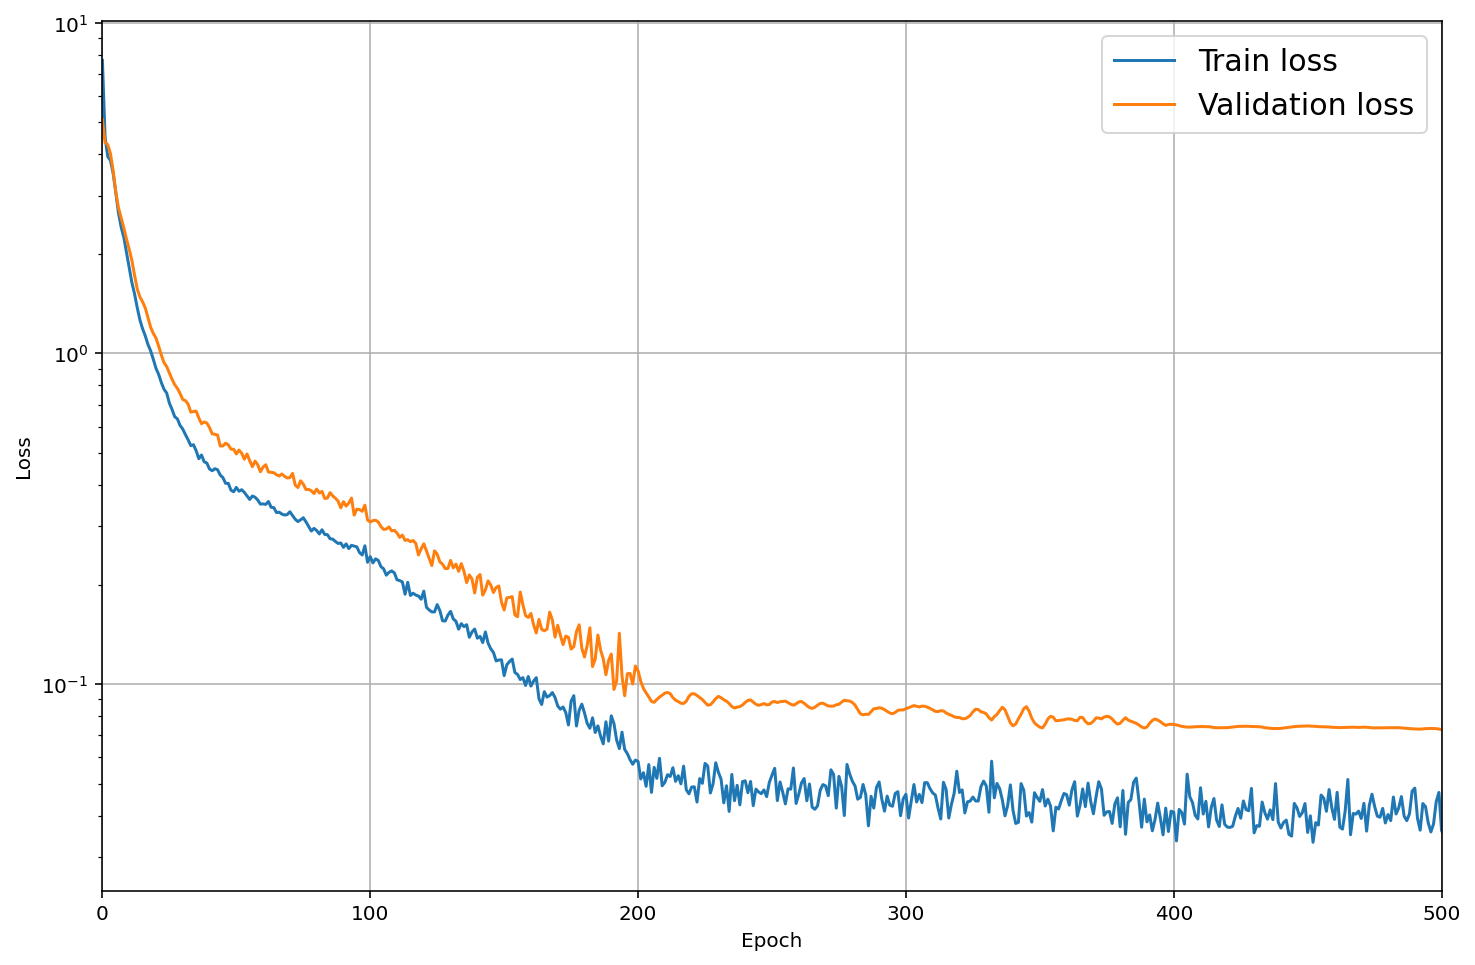

In [51]:
# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(train_loss, label='Train loss')
plt.semilogy(val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(0,500)
plt.grid('on')
plt.legend(loc=1,prop={'size': 15})
plt.show()

In [41]:
#loading the best model with early stopping
model = Net(Nh1=296,Nh2=209,drop1=0.003,drop2=0.013)
model.load_state_dict(torch.load('checkpoint.pt'))
model.eval()

Network initialized!


Net(
  (fc1): Linear(in_features=1, out_features=296, bias=True)
  (fc2): Linear(in_features=296, out_features=209, bias=True)
  (out): Linear(in_features=209, out_features=1, bias=True)
  (act): ReLU()
  (drop1): Dropout(p=0.003, inplace=False)
  (drop2): Dropout(p=0.013, inplace=False)
)

Input shape: torch.Size([1000, 1])
Output shape: torch.Size([1000, 1])


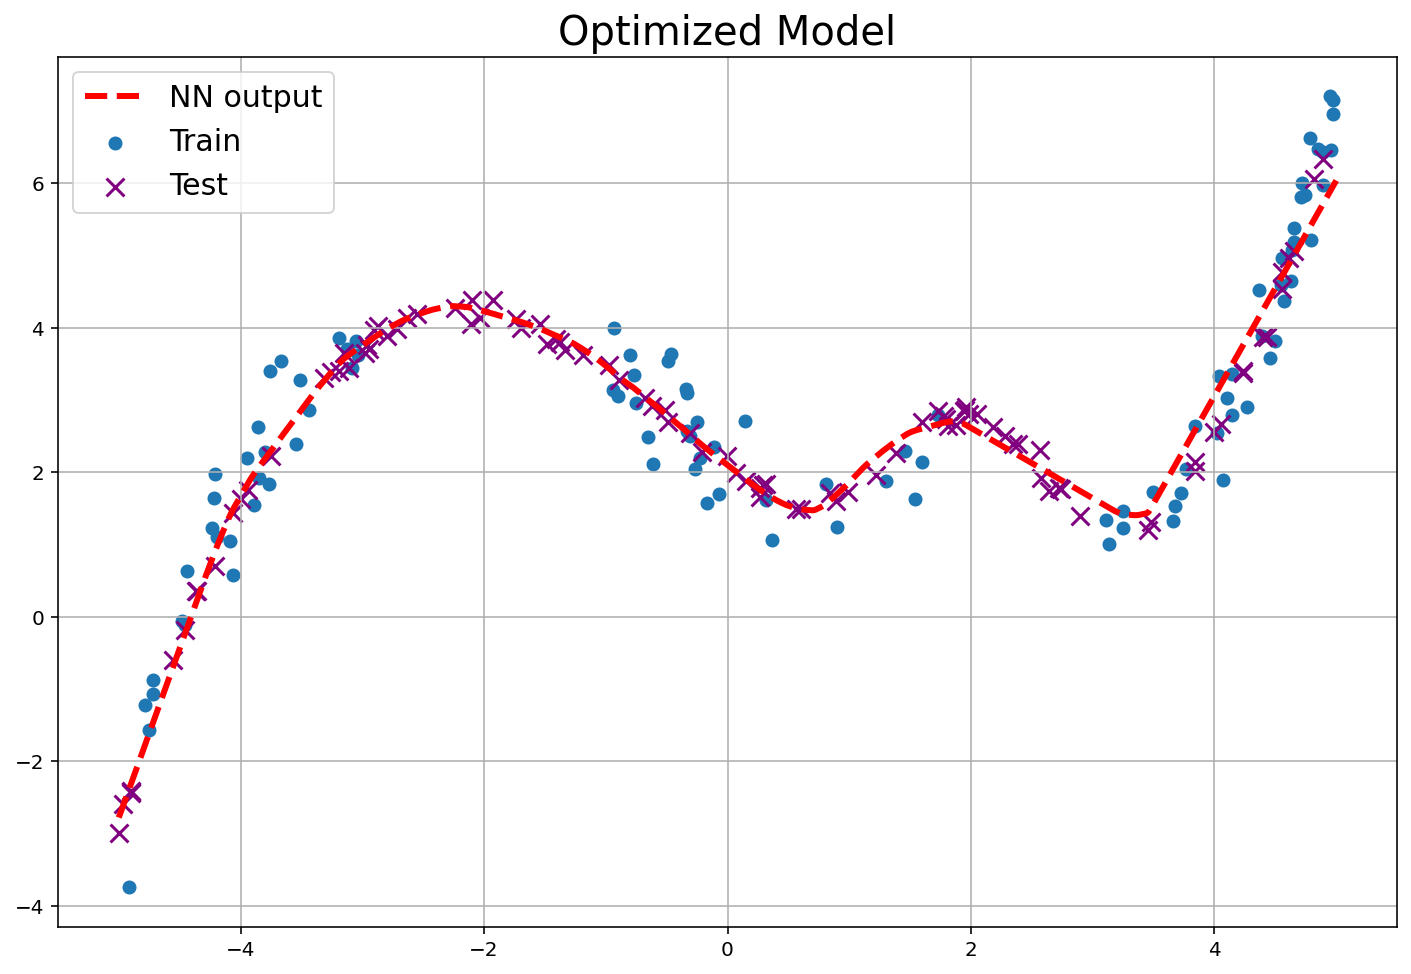

In [42]:
# Input vector
x_vec = torch.linspace(-5,5,1000)
x_vec = x_vec.unsqueeze(-1).to(device)  # Adding a dimension to the input vector
print(f"Input shape: {x_vec.shape}")

#with 
#y_vec = trainer.predict(litnet,x_vec)
#print(f"Output shape: {y_vec.shape}")
model.eval()
with torch.no_grad(): # turn off gradients computation
    y_vec = model(x_vec)
print(f"Output shape: {y_vec.shape}")


plt.figure(figsize=(12,8))
plt.title('Optimized Model',size=20)
plt.plot(x_vec,y_vec,'r--', label='NN output',linewidth=3)
plt.scatter(train_df.iloc[0:,0], train_df.iloc[0:,1], label='Train')
plt.scatter(test_df.iloc[0:,0], test_df.iloc[0:,1], label='Test',color='purple', marker='x',s=80)
plt.grid('on')
plt.legend(loc=2,prop={'size': 15})
plt.show()

## Inspecting Hidden Layers

In [43]:
# First hidden layer
net = model
h1_w = net.fc1.weight.data.cpu().numpy()
h1_b = net.fc1.bias.data.cpu().numpy()

# Second hidden layer
h2_w = net.fc2.weight.data.cpu().numpy()
h2_b = net.fc2.bias.data.cpu().numpy()

# Output layer
out_w = net.out.weight.data.cpu().numpy()
out_b = net.out.bias.data.cpu().numpy()

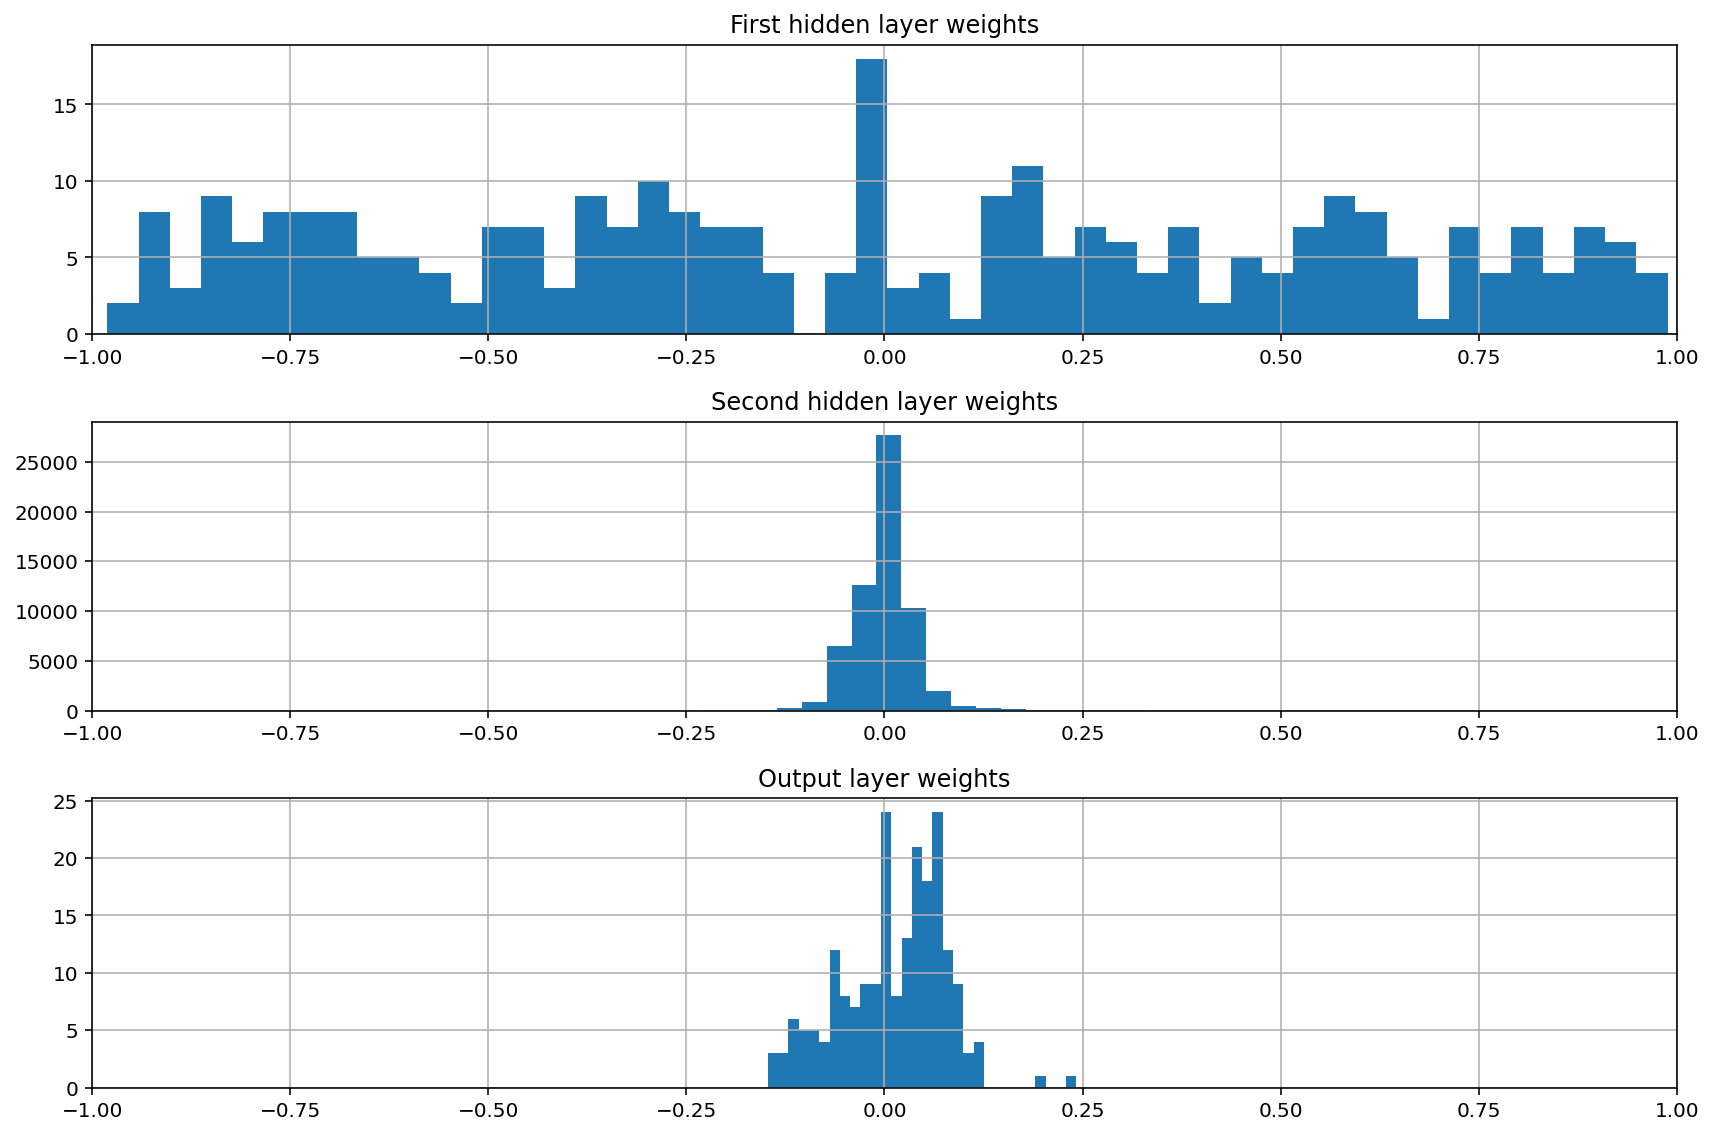

In [44]:
# Weights histogram
fig, axs = plt.subplots(3, 1, figsize=(12,8))
axs[0].hist(h1_w.flatten(), 50)
axs[0].set_title('First hidden layer weights')
axs[0].set_xlim([-1, 1])
axs[1].hist(h2_w.flatten(), 30)
axs[1].set_title('Second hidden layer weights')
axs[1].set_xlim([-1, 1])
axs[2].hist(out_w.flatten(), 30)
axs[2].set_title('Output layer weights')
axs[2].set_xlim([-1, 1])
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

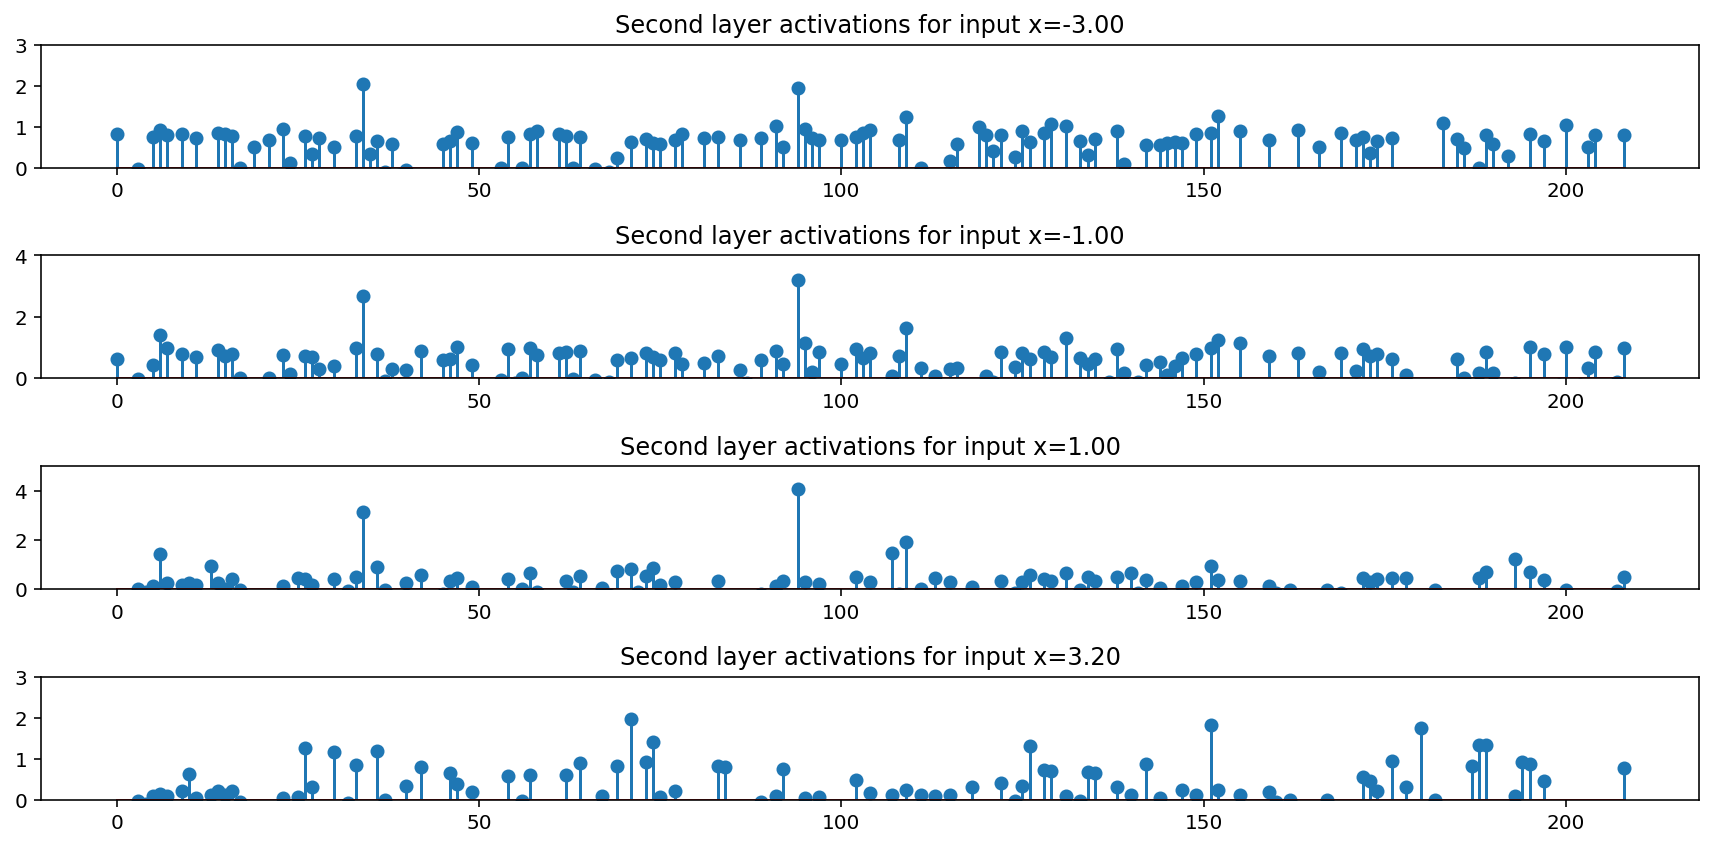

In [46]:
# First naive way: simply change the network definition to return an additional output

# More advanced strategy: using hooks

def get_activation(layer, input, output):
    global activation
    activation = (output) #########################################CONTROLLARESIGMOID ############################

### Register hook  
hook_handle = net.fc2.register_forward_hook(get_activation)

### Analyze activations
net = net.to(device)
net.eval()
with torch.no_grad():
    x1 = torch.tensor([-3]).float().to(device)
    y1 = net(x1)
    z1 = activation
    x2 = torch.tensor([-1]).float().to(device)
    y2 = net(x2)
    z2 = activation
    x3 = torch.tensor([1]).float().to(device)
    y3 = net(x3)
    z3 = activation
    x4 = torch.tensor([3.2]).float().to(device) #outside the range just to check the activations
    y4 = net(x4)
    z4 = activation

### Remove hook
hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(4, 1, figsize=(12,6))
axs[0].stem(z1.cpu().numpy(), use_line_collection=True)
axs[0].set_title('Second layer activations for input x=%.2f' % x1)
axs[0].set_ylim([0, 3])
axs[1].stem(z2.cpu().numpy(), use_line_collection=True)
axs[1].set_title('Second layer activations for input x=%.2f' % x2)
axs[1].set_ylim([0, 4])
axs[2].stem(z3.cpu().numpy(), use_line_collection=True)
axs[2].set_title('Second layer activations for input x=%.2f' % x3)
axs[2].set_ylim([0, 5])
axs[3].stem(z4.cpu().numpy(), use_line_collection=True)
axs[3].set_title('Second layer activations for input x=%.2f' % x4)
axs[3].set_ylim([0, 3])
plt.tight_layout()
plt.show()